# DENUE information

@roman

1 julio, 2024

In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import h3
from tqdm import tqdm
from dotenv import load_dotenv
from scipy.spatial import KDTree
# dbscan
from sklearn.cluster import DBSCAN
from INEGIpy import DENUE, MarcoGeoestadistico

In [2]:
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

# Load environment variables
load_dotenv()

# inegi class
denue_api = DENUE(token=os.getenv('API_INEGI'))
inegi_api = MarcoGeoestadistico()


---
# Data

## Cities

In [3]:
# read parquet
gdf_cities = gpd.read_parquet("../../data/misc/polygons_cities_analysis.parquet")

# change crs to 6372
gdf_cities = gdf_cities.to_crs("EPSG:6372")

gdf_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city_cluster  158 non-null    int64   
 1   geometry      158 non-null    geometry
 2   id_entidad_f  158 non-null    object  
 3   id_municipio  158 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 5.1+ KB


In [4]:
# Ensure we use lat/lon coordinates
def latlon_to_h3(latitudes, longitudes, resolution):
    # Ensure inputs are numpy arrays
    latitudes = np.asarray(latitudes)
    longitudes = np.asarray(longitudes)
    
    # Check that latitudes and longitudes are the same shape
    if latitudes.shape != longitudes.shape:
        raise ValueError("Latitudes and longitudes must be the same shape")
    
    # Vectorize the h3 function
    vectorized_h3 = np.vectorize(h3.geo_to_h3)
    
    # Apply the function to the latitude and longitude arrays
    hex_ids = vectorized_h3(latitudes, longitudes, resolution)
    
    return hex_ids

def to_latlon(gdf):
    if gdf.crs is not None and gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')
    return gdf

# Get all H3 hexagons covering a shapely geometry
def h3_polyfill(geometry, resolution):
    hexagons = set()
    if geometry.geom_type == 'Polygon':
        hexagons.update(h3.polyfill(geometry.__geo_interface__, resolution, geo_json_conformant=True))
    elif geometry.geom_type == 'MultiPolygon':
        for poly in geometry:
            hexagons.update(h3.polyfill(poly.__geo_interface__, resolution, geo_json_conformant=True))
    return hexagons

# Create GeoDataFrame of H3 hexagons from a set of H3 indices
def hexagons_to_geodf(hexagons, crs):
    # each hexagon to polygon
    polygons = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]
    # create geodataframe
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    return gdf

# Vectorized function to compute hexagons
def create_hex_grid_vectorized(gdf, resolution):
    # copy
    gdf = gdf.copy()

    # buffer by 1km the geometries
    gdf = gdf.to_crs('EPSG:6372')
    gdf['geometry'] = gdf['geometry'].buffer(1_000)

    # Convert GeoDataFrame to lat/lon if not already
    gdf = to_latlon(gdf)

    # Get H3 hexagons for all geometries
    hex_sets = np.array([h3_polyfill(geom, resolution) for geom in gdf['geometry']])
    
    # Flatten the hexagon sets
    all_hexagons = set().union(*hex_sets)

    # Convert H3 indices to GeoDataFrame
    hex_gdf = hexagons_to_geodf(all_hexagons, gdf.crs)

    # Get lon & lat
    hex_gdf['longitude'] = hex_gdf.centroid.x
    hex_gdf['latitude'] = hex_gdf.centroid.y

    # Get hex-id
    hex_gdf['hex_id'] = latlon_to_h3(
        hex_gdf['latitude'].values,
        hex_gdf['longitude'].values,
        resolution
    )

    return hex_gdf

# Define the H3 resolution
resolution = 7

# Create the hexagon grid
gdf_hex = create_hex_grid_vectorized(gdf_cities, resolution)
gdf_hex


/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_6704/182453498.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_gdf['longitude'] = hex_gdf.centroid.x
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_6704/182453498.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hex_gdf['latitude'] = hex_gdf.centroid.y


geometry   longitude  \
0     POLYGON ((-97.42807 20.93462, -97.41921 20.945...  -97.433518   
1     POLYGON ((-105.43592 28.22345, -105.42701 28.2... -105.442700   
2     POLYGON ((-99.04921 18.79182, -99.04056 18.802...  -99.054772   
3     POLYGON ((-99.18898 19.37803, -99.18030 19.389...  -99.194589   
4     POLYGON ((-106.09202 28.59339, -106.08314 28.6... -106.098898   
...                                                 ...         ...   
4477  POLYGON ((-97.53233 25.82295, -97.52312 25.833...  -97.538010   
4478  POLYGON ((-96.89052 19.43004, -96.88175 19.440...  -96.895835   
4479  POLYGON ((-90.48360 19.85870, -90.47470 19.868...  -90.488058   
4480  POLYGON ((-99.14814 18.86164, -99.13949 18.872...  -99.153715   
4481  POLYGON ((-110.96086 31.31271, -110.95225 31.3... -110.968396   

       latitude           hex_id  
0     20.947204  874993c41ffffff  
1     28.235962  87481a630ffffff  
2     18.804293  8749b32b5ffffff  
3     19.390544  874995ba5ffffff  
4     28.605871  87481b4b5ffffff  
...         ...              ...  
4477  25.835668  8748b0692ffffff  
4478  19.442547  874996045ffffff  
4479  19.871094  8745760cbffffff  
4480  18.874126  8749b32a9ffffff  
4481  31.324806  8748ec45bffffff  

[4482 rows x 4 columns]

In [5]:
# look for hexagons in the cities
gdf_hex.explore(tiles='cartodb positron', tooltip='hex_id')

^^^
note:
- hex with resolution 7 has a side length of 1.4km, which translates to an apothem of 1.2km and an area of 5.16km^2

## Mexico

In [6]:
# get mexico shapes
gdf_mexico = inegi_api.Entidades()
gdf_mexico.shape

(32, 9)

<Axes: >

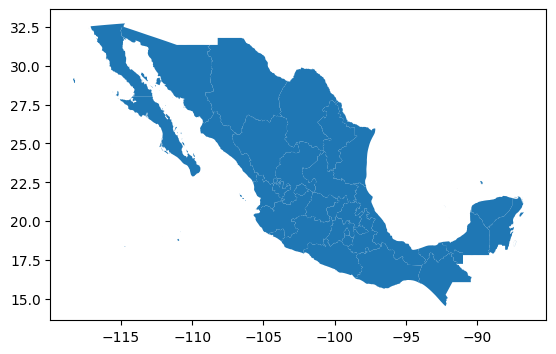

In [7]:
# plot
gdf_mexico.plot()

## Properties

In [43]:
# read properties
gdf_properties = gpd.read_parquet("../../data/interim/cleaned_data_s6.parquet")
gdf_properties.shape

(852913, 55)

In [44]:
# info
gdf_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 852913 entries, 0 to 852912
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   property_id                    852913 non-null  object        
 1   valor_fisico_construccion      852913 non-null  float64       
 2   id_avaluo                      852913 non-null  object        
 3   fecha_avaluo                   852913 non-null  datetime64[ns]
 4   colonia                        852913 non-null  object        
 5   id_clase_inmueble              852913 non-null  int64         
 6   id_tipo_inmueble               852913 non-null  int64         
 7   conservacion                   852913 non-null  float64       
 8   elevador                       824546 non-null  float64       
 9   niveles                        852913 non-null  int64         
 10  cve_ref_proximidad_urbana      852913 non-null  int64       

---
# Scouting Data

## How to fetch

### Buscar Method

In [6]:
# subset
gdf_hex_sample = gdf_hex.query("hex_id == '874995baeffffff'")
RADIUS = 5_000  # 1km

In [7]:
gdf_hex_sample

geometry  longitude   latitude  \
349  POLYGON ((-99.18283 19.42507, -99.17415 19.436... -99.188437  19.437583   

              hex_id  
349  874995baeffffff

In [8]:
# search denue
gdf_supermarkets = denue_api.Buscar(
    'walmart, oxxo',
    latitud=gdf_hex_sample['latitude'].values[0],
    longitud=gdf_hex_sample['longitude'].values[0],
    distancia=RADIUS
)
# see
gdf_supermarkets

https://www.inegi.org.mx/app/api/denue/v1/consulta/Buscar/walmart, oxxo/19.4375834332844,-99.18843720864304/5000/b4f50704-61f4-4343-8aeb-79c7e12761c4


CLEE       Id  \
0    09016462112000932000008202S5  6315366   
1    09016462112000612000008202S3  6325066   
2    09016462112001722000008202S9  6307292   
3    09016462112003362000008202S2  9396516   
4    09016462112002372000008202S2  6706023   
..                            ...      ...   
327  09015462112003462000008202S2  6317650   
328  09014462112004502000008202S7  9392847   
329  09015462112007112000008202S9  9436453   
330  09015462112004661001008202S8  6723810   
331  15057462112002992000008202S3  9415996   

                                  Nombre                    Razon_social  \
0               OXXO SUC 50HEG HEGEL MEX  CADENA COMERCIAL OXXO SA DE CV   
1            OXXO SUC 50EJC EJERCITO MEX  CADENA COMERCIAL OXXO SA DE CV   
2             OXXO SUC 50WOB MARIANO MEX  CADENA COMERCIAL OXXO SA DE CV   
3         OXXO SUC 50T27 LAGO ALBERTO II  CADENA COMERCIAL OXXO SA DE CV   
4    OXXO SUC 50LIS PLAZA ARQUIMIDES MEX  CADENA COMERCIAL OXXO SA DE CV   
..                                   ...                             ...   
327        OXXO SUC 50XYJ DOCTORES I MEX  CADENA COMERCIAL OXXO SA DE CV   
328           OXXO SUC 50XU9 ARIZONA MEX  CADENA COMERCIAL OXXO SA DE CV   
329         OXXO SUC 50J10 DR PASCUA MEX  CADENA COMERCIAL OXXO SA DE CV   
330   OXXO SUC 50QUR RIVA PALACIO II MEX  CADENA COMERCIAL OXXO SA DE CV   
331          OXXO SUC 50M2J PUERTA 7 MEX  CADENA COMERCIAL OXXO SA DE CV   

                         Clase_actividad          Estrato Tipo_vialidad  \
0    Comercio al por menor en minisupers  6 a 10 personas       AVENIDA   
1    Comercio al por menor en minisupers  6 a 10 personas       AVENIDA   
2    Comercio al por menor en minisupers  6 a 10 personas       AVENIDA   
3    Comercio al por menor en minisupers  6 a 10 personas         CALLE   
4    Comercio al por menor en minisupers  6 a 10 personas         CALLE   
..                                   ...              ...           ...   
327  Comercio al por menor en minisupers  6 a 10 personas         CALLE   
328  Comercio al por menor en minisupers  6 a 10 personas         CALLE   
329  Comercio al por menor en minisupers  6 a 10 personas         CALLE   
330  Comercio al por menor en minisupers  6 a 10 personas      EJE VIAL   
331  Comercio al por menor en minisupers  6 a 10 personas         CALLE   

                           Calle Num_Exterior Num_Interior  \
0    EJÃ¿RCITO NACIONAL MEXICANO          430                
1    EJÃ¿RCITO NACIONAL MEXICANO          505                
2       GENERAL MARIANO ESCOBEDO          373                
3                   LAGO ALBERTO                             
4                    ARQUÃMEDES          130                
..                           ...          ...          ...   
327           DOCTOR JOSÉ TERRÉS           29                
328                      ARIZONA                             
329            DOCTOR VALENZUELA                             
330        1 PONIENTE (GUERRERO)          395                
331            CALZ. SAN ESTEBAN                             

                 Colonia     CP  \
0        POLANCO REFORMA  11550   
1                GRANADA  11520   
2                ANAHUAC  11320   
3                ANAHUAC  11320   
4    POLANCO CHAPULTEPEC  11560   
..                   ...    ...   
327             DOCTORES  06720   
328              NAPOLES  03810   
329             DOCTORES  06720   
330  NONOALCO TLATELOLCO  06900   
331          SAN ESTEBAN  53550   

                                             Ubicacion Telefono  \
0     MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO            
1     MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO            
2     MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO            
3     MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO            
4     MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO            
..                                                 ...      ...   
327           CUAUHTÉMOC, C

notes:
- if it doesnt find any supermarket then it breaks with an ConnectionError, `BadStatusLine('HTTP/1.1 000 \r\n')`

todo:
- define names of supermarkets, hospitals and schools to search
- minimum estrata to count 
- type of `tipo`
- maybe define razon social to always count the same type

### BuscarAreaActEstr Method

In [24]:
# search all supermarkets
gdf_supermarkets_cdmx = denue_api.BuscarAreaAct(
    nombre='supermercado',
    clave_area='00',
    # clave_actividad='462111',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)
# see
gdf_supermarkets_cdmx

CLEE       Id                      Nombre  \
0     11017462111000147000003517S6  6330332       010 LA COMER IRAPUATO   
1     15104462111000326000003517S9  6354328       012 LACOMER EL DORADO   
2     15037462111000066000003517S6  6353986  014 LA COMER LOMAS ANAHUAC   
3     09012462111000086000003517S9  6314534        017 LA COMER TLALPAN   
4     16102462111000076000003517S4  6358942        034 LA COMER URUAPAN   
...                            ...      ...                         ...   
7423  12075461110007071000000000U1  8420963                  YULI SUPER   
7424  09004462111000171000000000U8  9439732                    ZIEDIMEX   
7425  16066462111000093000058299S4  9405091       ZUPER CODALLOS LA ERA   
7426  16066462111000082000058299S7  9453171       ZUPER CODALLOS LA ERA   
7427  18020462111000131000000000U7  8718673               ZUPER EXPRESS   

                             Razon_social  \
0     COMERCIAL CITY FRESKO S DE RL DE CV   
1     COMERCIAL CITY FRESKO S DE RL DE CV   
2     COMERCIAL CITY FRESKO S DE RL DE CV   
3     COMERCIAL CITY FRESKO S DE RL DE CV   
4     COMERCIAL CITY FRESKO S DE RL DE CV   
...                                   ...   
7423                                        
7424                    ZIEDIMEX SA DE CV   
7425             VICA ABARROTERA SA DE CV   
7426             VICA ABARROTERA SA DE CV   
7427                                        

                             Clase_actividad             Estrato  \
0     Comercio al por menor en supermercados  101 a 250 personas   
1     Comercio al por menor en supermercados  251 y más personas   
2     Comercio al por menor en supermercados  251 y más personas   
3     Comercio al por menor en supermercados  101 a 250 personas   
4     Comercio al por menor en supermercados  101 a 250 personas   
...                                      ...                 ...   
7423  Comercio al por menor en supermercados      0 a 5 personas   
7424  Comercio al por menor en supermercados      0 a 5 personas   
7425  Comercio al por menor en supermercados    11 a 30 personas   
7426  Comercio al por menor en supermercados     6 a 10 personas   
7427  Comercio al por menor en supermercados      0 a 5 personas   

     Tipo_vialidad                          Calle Num_Exterior Num_Interior  \
0            CALLE               CALLE DEL BOSQUE            1                
1            CALLE                         ATENAS            6                
2          AVENIDA                  DE LAS PALMAS            1            2   
3            CALLE                   AYUNTAMIENTO            1                
4            CALLE  PASEO GENERAL LÁZARO CÁRDENAS         1800                
...            ...                            ...          ...          ...   
7423       AVENIDA                20 DE NOVIEMBRE                             
7424         CALLE         SAN JOSÉ DE LOS CEDROS           10                
7425         CALLE                          TRIGO                             
7426         CALLE                       EL PEAJE          193                
7427       AVENIDA                       ESTRELLA                       101   

                        Colonia     CP  \
0                    LAS REYNAS  36660   
1                  VALLE DORADO  54020   
2     SAN FERNANDO HUIXQUILUCAN  52784   
3                       LA FAMA  14110   
4                   LOS ANGELES  60160   
...                         ...    ...   
7423                SANTA ANITA  40185   
7424     SAN JOSE DE LOS CEDROS  05200   
7425                   ERENDIRA  61605   
7426                 LA ILUSION  61605   
7427            VALLE ESMERALDA  63737   

                                              Ubicacion    Telefono  \
0                        IRAPUATO, Irapuato, GUANAJUATO               
1     TLALNEPANTLA, Tlalnepantla de Baz, MÉXICO     ...               
2     NAUCALPAN DE JUÁREZ, Huixquilucan, MÉXICO     ...               
3                    TLALPAN, Tla

In [22]:
# search all supermarkets
gdf_hospitals_all_mex = denue_api.BuscarAreaAct(
    nombre='hospital',
    clave_area='00',
    # clave_actividad='462111',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)
# see
gdf_hospitals_all_mex

CLEE       Id  \
0      22014621113002531010000000U7  3563539   
1      14039622311000583001000000U6  1960097   
2      22014622311000681000000000U9  9330411   
3      22014621113007071010000000U9  3594860   
4      22014621113005771010000000U6  3594880   
...                             ...      ...   
11010  14096811430000021000000000U6  1642634   
11011  24028541943000011000000000U7  3667649   
11012  06010541941000151000000000U5   339459   
11013  31050541941002391000000000U0  7287963   
11014  15121812990000401000000000U7  2221841   

                                               Nombre    Razon_social  \
0                          1T410 CONSULTORIO UROLOGIA                   
1      261 HOSPITAL SN JOSE PARA ENFERMOS DE LA VISTA                   
2                                 2T101 CANCER CENTER  CANCER CENTER    
3                        2T202 CONSULTORIO PEDIATRICO                   
4                         2T614 CONSULTORIO PEDIATRIA                   
...                                               ...             ...   
11010                     ZAPATERO HOSPITAL DELZAPATO                   
11011                     ZEEBRA HOSPITAL VETERINARIO                   
11012        ZOO MASCOTA CLINICA HOSPITAL VETERINARIO                   
11013                 ZOOANIMALS HOSPITAL VETERINARIO                   
11014                                    ZOO-HOSPITAL                   

                                         Clase_actividad           Estrato  \
0      Hospitales del sector privado de otras especia...    0 a 5 personas   
1      Consultorios de medicina especializada del sec...  31 a 50 personas   
2      Hospitales del sector privado de otras especia...  31 a 50 personas   
3      Hospitales del sector privado de otras especia...    0 a 5 personas   
4      Hospitales del sector privado de otras especia...    0 a 5 personas   
...                                                  ...               ...   
11010  Reparación de calzado y otros artículos de pie...    0 a 5 personas   
11011  Servicios veterinarios para mascotas prestados...   6 a 10 personas   
11012  Servicios veterinarios para mascotas prestados...    0 a 5 personas   
11013  Servicios veterinarios para mascotas prestados...    0 a 5 personas   
11014                         Otros servicios personales    0 a 5 personas   

      Tipo_vialidad                Calle Num_Exterior Num_Interior  \
0           PRIVADA     IGNACIO ZARAGOZA           16          410   
1             CALLE         ANDRES TERAN          261                
2           PRIVADA     Ignacio Zaragoza         2351          101   
3           PRIVADA     IGNACIO ZARAGOZA           16          202   
4           PRIVADA     IGNACIO ZARAGOZA           16          614   
...             ...                  ...          ...          ...   
11010         CALLE             LIBERTAD            8                
11011         CALLE      LUIS DE VELASCO          195                
11012         CALLE      PASEO DE CEDROS            2                
11013         CALLE               61 (3)            0            0   
11014         CALLE  BOSQUES DE BOLOGNIA          172            3   

                     Colonia     CP  \
0                EL CARRIZAL  76030   
1                 VILLASEÑOR  44600   
2                EL CARRIZAL  76030   
3                EL CARRIZAL  76030   
4                EL CARRIZAL  76030   
...                      ...    ...   
11010        TIZAPAN EL ALTO  49400   
11011                POLANCO  78220   
11012  VILLAS DE BUGAMBILIAS  28979   
11013   FRANCISCO DE MONTEJO  97203   
11014       BOSQUES DEL LAGO  54766   

                                               Ubicacion    Telefono  \
0      SANTIAGO DE QUERÉTARO, Querétaro, QUERÉTARO   ...  4422955309   
1                      GUADALAJARA, Guadalajara, JALISCO               
2      SANTIAGO DE QUERÉTARO, Querétaro, QUERÉTARO   ...  4422013299   
3      SANTIAGO DE QUERÉTARO, Querétaro, Q

^^^
notes:
- easier way to fetch all the important places in the country

## Supermarkets Analysis

### Fetch All info

In [8]:
# search for supermarkets
gdf_supermarkets_mex = denue_api.BuscarAreaAct(
    nombre='supermercado',
    clave_area='00',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)

# see shape
gdf_supermarkets_mex.shape

(7428, 35)

In [9]:
# see a sample
gdf_supermarkets_mex.sample(5)

CLEE       Id  \
2844  13077462111000184000000000U1  9283018   
1863  24028462111000363000002514S1  6391973   
1383  22011462111000023000002514S9  6380725   
2224  11002462111000074000002514S4  8756614   
2207  23004462111000136000002514S3  6714720   

                                   Nombre  \
2844                  BODEGA MULTISUPERET   
1863      BA EXPRESS VALLE DE DALIAS 3703   
1383       BA EXPRESS GEO LA PRADERA 3982   
2224  BODEGA AURRERA EMILIO CARRANZA 2358   
2207         BODEGA AURRERA CHETUMAL 3527   

                                Razon_social  \
2844                   MULTISUPERET SA DE CV   
1863  NUEVA WAL MART DE MEXICO S DE RL DE CV   
1383  NUEVA WAL MART DE MEXICO S DE RL DE CV   
2224  NUEVA WAL MART DE MEXICO S DE RL DE CV   
2207  NUEVA WAL MART DE MEXICO S DE RL DE CV   

                             Clase_actividad             Estrato  \
2844  Comercio al por menor en supermercados    31 a 50 personas   
1863  Comercio al por menor en supermercados    11 a 30 personas   
1383  Comercio al por menor en supermercados    11 a 30 personas   
2224  Comercio al por menor en supermercados   51 a 100 personas   
2207  Comercio al por menor en supermercados  101 a 250 personas   

     Tipo_vialidad                            Calle Num_Exterior Num_Interior  \
2844         CALLE                  SAN LUIS POTOSI                             
1863  PROLONGACION                   AVENIDA DALIAS                             
1383     CARRETERA  ANILLO VIAL FRAY JUNÍPERO SERRA                             
2224         CALLE                  EMILIO CARRANZA           95                
2207       AVENIDA            CONSTITUYENTES DEL 74                             

                    Colonia     CP  \
2844            INSURGENTES  43630   
1863  INDUSTRIAL TANGAMANGA  78343   
1383             LA PRADERA  76269   
2224        EMILIO CARRANZA  38680   
2207    ANDRES QUINTANA ROO  77086   

                                              Ubicacion Telefono Correo_e  \
2844           TULANCINGO, Tulancingo de Bravo, HIDALGO                     
1863  SAN LUIS POTOSÍ, San Luis Potosí, SAN LUIS POT...                     
1383  LA PRADERA, El Marqués, QUERÉTARO             ...                     
2224                     ACÁMBARO, Acámbaro, GUANAJUATO                     
2207            CHETUMAL, Othón P. Blanco, QUINTANA ROO                     

          Sitio_internet  Tipo    Longitud    Latitud  \
2844                      Fijo  -98.362584  20.092871   
1863  WWW.WALMART.COM.MX  Fijo -100.935331  22.125310   
1383  WWW.WALMART.COM.MX  Fijo -100.342876  20.654266   
2224  WWW.WALMART.COM.MX  Fijo -100.712543  20.037630   
2207  WWW.WALMART.COM.MX  Fijo  -88.293929  18.523710   

     tipo_corredor_industrial nom_corredor_industrial numero_local  AGEB  \
2844                                                                0018   
1863                                                                3849   
1383                                                                0301   
2224                                                                0499   
2207                                                                0462   

     Manzana CLASE_ACTIVIDAD_ID EDIFICIO_PISO SECTOR_ACTIVIDAD_ID  \
2844     006             462111                                46   
1863     026             462111                                46   
1383     017             462111                                46   
2224     007             462111                                46   
2207     010             462111                                46   

     SUBSECTOR_ACTIVIDAD_ID RAMA_ACTIVIDAD_ID SUBRAMA_ACTIVIDAD_ID EDIFICIO  \
2844                    462              4621                46211            
1863                    462              4621                46211            
1383                    462              4621                46211            
2224                    462              4621                46211  

### Mini EDA

<Axes: >

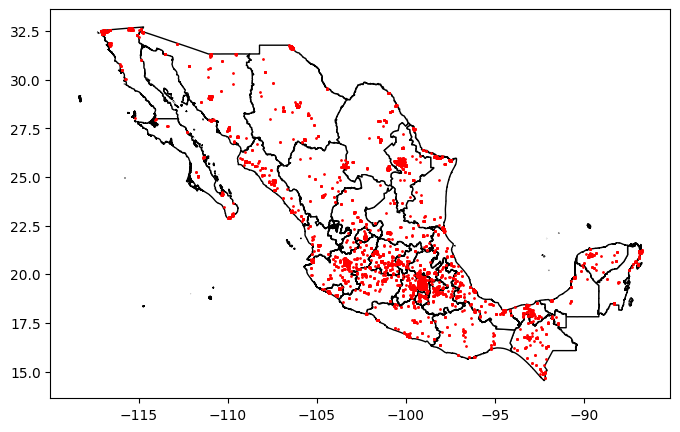

In [10]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_supermarkets_mex.plot(ax=ax, color='red', markersize=1)


In [11]:
# see clase_actividad_id
gdf_supermarkets_mex['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
462111    7190
462112      87
461110      64
461212      27
431110      11
461121       9
435319       6
467112       4
461160       4
465915       4
461130       3
461150       2
561330       2
311612       2
431121       1
466111       1
813120       1
541610       1
468211       1
467111       1
531311       1
434211       1
722513       1
461190       1
465919       1
522110       1
465914       1
Name: count, dtype: int64

we want:
- 462111: super comercio al por menor supermercados
- 462112: minisupers idem


In [12]:
# razon social
gdf_supermarkets_mex['Razon_social'].value_counts().head(30)

Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        2915
TIENDAS SORIANA SA DE CV                       823
WALDOS DOLAR MART DE MEXICO S DE RL DE CV      579
                                               563
TIENDAS CHEDRAUI SA DE CV                      327
CASA LEY SAPI DE CV                            254
QAR SUPERMERCADOS SAPI DE CV                   114
CENTRAL DETALLISTA SA DE CV                    107
CORPORACION SANCHEZ SA DE CV                    92
COMERCIAL CITY FRESKO S DE RL DE CV             91
OPERADORA FUTURAMA SA DE CV                     88
SUPERMERCADOS INTERNACIONALES HEB SA DE CV      77
SUPERISSSTE                                     63
INSTITUTO MEXICANO DEL SEGURO SOCIAL            55
SUPER SAN FRANCISCO DE ASIS SA DE CV            53
COMERCIALIZADORA GRUPO SCORPION SA DE CV        49
OPERADORA DE CIUDAD JUAREZ SA DE CV             44
TIENDA DE DESCUENTO ARTELI SA DE CV             44
OPERADORA DE REYNOSA SA DE CV                   42
COSTCO DE MEXICO S

important supermarkets:

- NUEVA WAL MART DE MEXICO S DE RL DE CV
- TIENDAS SORIANA SA DE CV                       
- TIENDAS CHEDRAUI SA DE CV                      
- CASA LEY SAPI DE CV                            
- QAR SUPERMERCADOS SAPI DE CV                   
- CORPORACION SANCHEZ SA DE CV                   
- COMERCIAL CITY FRESKO S DE RL DE CV            
- OPERADORA FUTURAMA SA DE CV                    
- SUPERMERCADOS INTERNACIONALES HEB SA DE CV     
- SUPERISSSTE                                   
- INSTITUTO MEXICANO DEL SEGURO SOCIAL          
- SUPER SAN FRANCISCO DE ASIS SA DE CV          
- COSTCO DE MEXICO SA DE CV                     

In [13]:
# count estrato
gdf_supermarkets_mex['Estrato'].value_counts()

Estrato
11 a 30 personas      1953
101 a 250 personas    1876
51 a 100 personas     1513
0 a 5 personas         987
31 a 50 personas       557
6 a 10 personas        431
251 y más personas     111
Name: count, dtype: int64

In [14]:
pd.to_datetime(gdf_supermarkets_mex['Fecha_Alta'], format='%Y-%m', errors='coerce').describe()

count                             7421
mean     2015-03-17 09:06:25.662309888
min                2010-07-01 00:00:00
25%                2010-07-01 00:00:00
50%                2014-12-01 00:00:00
75%                2019-11-01 00:00:00
max                2024-05-01 00:00:00
Name: Fecha_Alta, dtype: object

<Axes: xlabel='Fecha_Alta'>

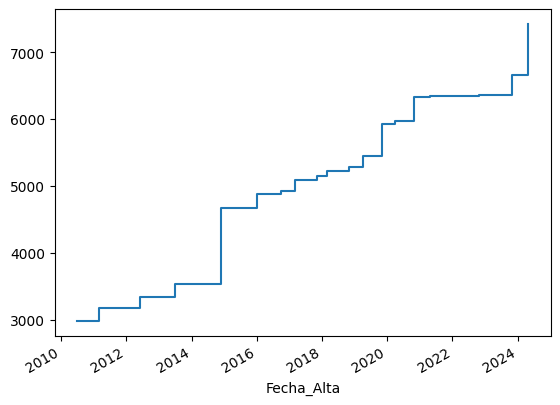

In [15]:
# time series of counts of Fecha_Alta: the date format is 'YYYY-MM'
gdf_supermarkets_mex['Fecha_Alta'] = pd.to_datetime(gdf_supermarkets_mex['Fecha_Alta'], format='%Y-%m', errors='coerce')

# plot ts
(
    gdf_supermarkets_mex
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)

<Axes: xlabel='id_sentidad_f'>

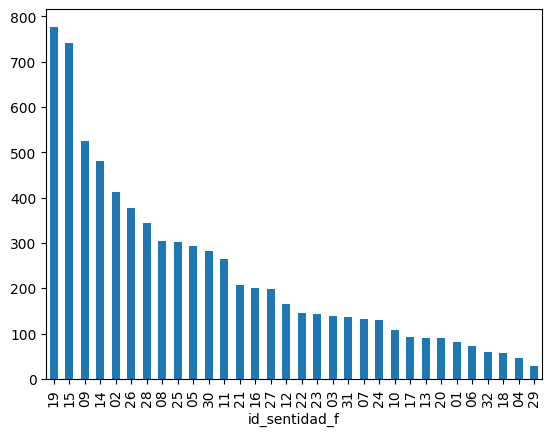

In [16]:
# see distributio by id_entidad_f
gdf_supermarkets_mex['id_sentidad_f'] = gdf_supermarkets_mex['AreaGeo'].str[:2]
gdf_supermarkets_mex['id_sentidad_f'].value_counts().plot(kind='bar')

### Filter

In [17]:
# params
clase_actividad_list = [
    462111
]

# important supermarkets
important_supermarkets = [
    'NUEVA WAL MART DE MEXICO S DE RL DE CV',
    'TIENDAS SORIANA SA DE CV',
    'TIENDAS CHEDRAUI SA DE CV',
    'CASA LEY SAPI DE CV',
    'QAR SUPERMERCADOS SAPI DE CV',
    'CORPORACION SANCHEZ SA DE CV',
    'COMERCIAL CITY FRESKO S DE RL DE CV',
    'OPERADORA FUTURAMA SA DE CV',
    'SUPERMERCADOS INTERNACIONALES HEB SA DE CV',
    'SUPERISSSTE',
    'INSTITUTO MEXICANO DEL SEGURO SOCIAL',
    'SUPER SAN FRANCISCO DE ASIS SA DE CV',
    'COSTCO DE MEXICO SA DE CV'
]

# estrato levels
estrato_categories = [
    '0 a 5 personas',
    '6 a 10 personas',
    '11 a 30 personas',
    '31 a 50 personas',
    '51 a 100 personas',
    '101 a 250 personas',
    '251 y más personas'
]

# important columns
vars_to_stay = [
    'CLEE', 'Nombre', 'Razon_social', 'Clase_actividad', 'estrato_category',
    'CLASE_ACTIVIDAD_ID', 'AreaGeo', 'id_entidad_f', 'Fecha_Alta', 'geometry'
]

In [18]:
# modify dataframe
gdf_supermarkets_mex2 = (
    gdf_supermarkets_mex
    .assign(
        estrato_category=lambda x: pd.Categorical(
            x['Estrato'],
            categories=estrato_categories,
            ordered=True
        ),
        Razon_social=lambda x: 
            x['Razon_social'].str.strip().str.upper(),
        id_entidad_f=lambda x: x['AreaGeo'].str[:2],
        Fecha_Alta=lambda x: pd.to_datetime(
            x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
    )
    .astype({
        'CLASE_ACTIVIDAD_ID': 'int64'
    })
    # filters
    .query("CLASE_ACTIVIDAD_ID.isin(@clase_actividad_list)")
    .query("Razon_social.isin(@important_supermarkets)")
    .query("estrato_category >= '11 a 30 personas'")
    .reset_index(drop=True)
    .loc[:, vars_to_stay]
)
gdf_supermarkets_mex2

CLEE                                   Nombre  \
0     11017462111000147000003517S6                    010 LA COMER IRAPUATO   
1     15104462111000326000003517S9                    012 LACOMER EL DORADO   
2     15037462111000066000003517S6               014 LA COMER LOMAS ANAHUAC   
3     09012462111000086000003517S9                     017 LA COMER TLALPAN   
4     16102462111000076000003517S4                     034 LA COMER URUAPAN   
...                            ...                                      ...   
4642  22014462111001035000002514S6  WALMART EXPRESS PABELLON CAMPESTRE 4581   
4643  11020462111000746000002514S9                WALMART LA ANTORCHA  1621   
4644  20390462111000016000002514S3                 WALMART MACRO PLAZA 1804   
4645  13050462111000015000002514S4         WALMART VALLE DEL MEZQUITAL 3050   
4646  11020462111000156000002514S1                   WALT MART TORRES LANDA   

                                Razon_social  \
0        COMERCIAL CITY FRESKO S DE RL DE CV   
1        COMERCIAL CITY FRESKO S DE RL DE CV   
2        COMERCIAL CITY FRESKO S DE RL DE CV   
3        COMERCIAL CITY FRESKO S DE RL DE CV   
4        COMERCIAL CITY FRESKO S DE RL DE CV   
...                                      ...   
4642  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4643  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4644  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4645  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4646  NUEVA WAL MART DE MEXICO S DE RL DE CV   

                             Clase_actividad    estrato_category  \
0     Comercio al por menor en supermercados  101 a 250 personas   
1     Comercio al por menor en supermercados  251 y más personas   
2     Comercio al por menor en supermercados  251 y más personas   
3     Comercio al por menor en supermercados  101 a 250 personas   
4     Comercio al por menor en supermercados  101 a 250 personas   
...                                      ...                 ...   
4642  Comercio al por menor en supermercados   51 a 100 personas   
4643  Comercio al por menor en supermercados  101 a 250 personas   
4644  Comercio al por menor en supermercados  101 a 250 personas   
4645  Comercio al por menor en supermercados   51 a 100 personas   
4646  Comercio al por menor en supermercados  101 a 250 personas   

      CLASE_ACTIVIDAD_ID    AreaGeo id_entidad_f Fecha_Alta  \
0                 462111  110170001           11 2010-07-01   
1                 462111  151040001           15 2010-07-01   
2                 462111  150370071           15 2010-07-01   
3                 462111  090120001           09 2010-07-01   
4                 462111  161020001           16 2010-07-01   
...                  ...        ...          ...        ...   
4642              462111  220060044           22 2024-05-01   
4643              462111  110200001           11 2016-01-01   
4644              462111  203900001           20 2016-01-01   
4645              462111  130500001           13 2010-07-01   
4646              462111  110200001           11 2024-05-01   

                         geometry  
0     POINT (-101.35774 20.69011)  
1      POINT (-99.21389 19.54638)  
2      POINT (-99.27475 19.39943)  
3      POINT (-99.17940 19.28945)  
4     POINT (-102.05535 19.40129)  
...                           ...  
4642  POINT (-100.41220 20.56049)  
4643  POINT (-101.73356 21.17324)  
4644   POINT (-96.69440 17.06862)  
4645   POINT (-99.19269 20.24038)  
4646  POINT (-101.66003 21.09778)  

[4647 rows x 10 columns]

### Mini EDA of Filtered Info

<Axes: >

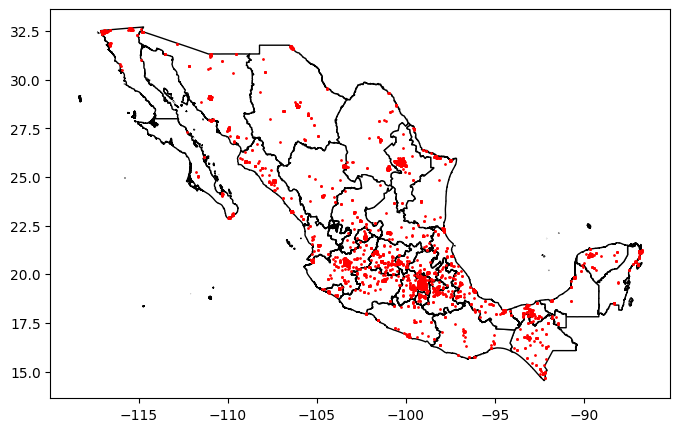

In [19]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_supermarkets_mex2.plot(ax=ax, color='red', markersize=1)


In [20]:
# see clase_actividad_id
gdf_supermarkets_mex2['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
462111    4647
Name: count, dtype: int64

In [21]:
# razon social
gdf_supermarkets_mex2['Razon_social'].value_counts(normalize=True)

Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        0.574779
TIENDAS SORIANA SA DE CV                      0.174091
TIENDAS CHEDRAUI SA DE CV                     0.069077
CASA LEY SAPI DE CV                           0.052077
QAR SUPERMERCADOS SAPI DE CV                  0.021519
COMERCIAL CITY FRESKO S DE RL DE CV           0.018937
OPERADORA FUTURAMA SA DE CV                   0.018291
SUPERMERCADOS INTERNACIONALES HEB SA DE CV    0.014848
CORPORACION SANCHEZ SA DE CV                  0.014848
SUPERISSSTE                                   0.012266
SUPER SAN FRANCISCO DE ASIS SA DE CV          0.010975
INSTITUTO MEXICANO DEL SEGURO SOCIAL          0.009899
COSTCO DE MEXICO SA DE CV                     0.008393
Name: proportion, dtype: float64

<Axes: xlabel='estrato_category'>

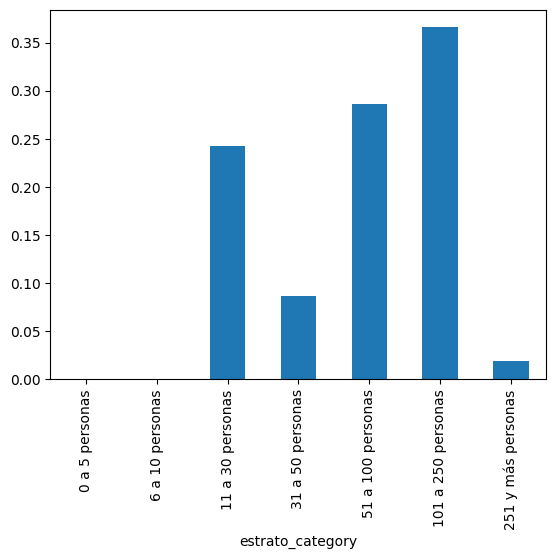

In [22]:
# count estrato
gdf_supermarkets_mex2['estrato_category'].value_counts(normalize=True).sort_index().plot(kind='bar')

In [23]:
# describe
gdf_supermarkets_mex2['Fecha_Alta'].describe()

count                             4643
mean     2014-08-28 03:18:10.932586752
min                2010-07-01 00:00:00
25%                2010-07-01 00:00:00
50%                2013-07-01 00:00:00
75%                2017-03-01 00:00:00
max                2024-05-01 00:00:00
Name: Fecha_Alta, dtype: object

<Axes: xlabel='Fecha_Alta'>

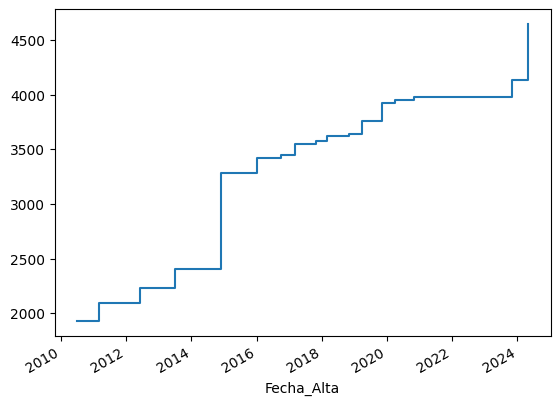

In [24]:
# plot ts
(
    gdf_supermarkets_mex2
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)

<Axes: xlabel='id_entidad_f'>

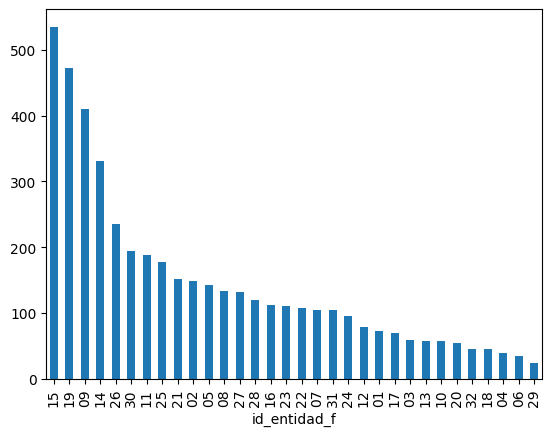

In [25]:
# see distributio by id_entidad_f
gdf_supermarkets_mex2['id_entidad_f'].value_counts().plot(kind='bar')

In [26]:
# razon social
gdf_supermarkets_mex2['Razon_social'].value_counts().head(30)

Razon_social
NUEVA WAL MART DE MEXICO S DE RL DE CV        2671
TIENDAS SORIANA SA DE CV                       809
TIENDAS CHEDRAUI SA DE CV                      321
CASA LEY SAPI DE CV                            242
QAR SUPERMERCADOS SAPI DE CV                   100
COMERCIAL CITY FRESKO S DE RL DE CV             88
OPERADORA FUTURAMA SA DE CV                     85
SUPERMERCADOS INTERNACIONALES HEB SA DE CV      69
CORPORACION SANCHEZ SA DE CV                    69
SUPERISSSTE                                     57
SUPER SAN FRANCISCO DE ASIS SA DE CV            51
INSTITUTO MEXICANO DEL SEGURO SOCIAL            46
COSTCO DE MEXICO SA DE CV                       39
Name: count, dtype: int64

In [27]:
gdf_supermarkets_mex2

CLEE                                   Nombre  \
0     11017462111000147000003517S6                    010 LA COMER IRAPUATO   
1     15104462111000326000003517S9                    012 LACOMER EL DORADO   
2     15037462111000066000003517S6               014 LA COMER LOMAS ANAHUAC   
3     09012462111000086000003517S9                     017 LA COMER TLALPAN   
4     16102462111000076000003517S4                     034 LA COMER URUAPAN   
...                            ...                                      ...   
4642  22014462111001035000002514S6  WALMART EXPRESS PABELLON CAMPESTRE 4581   
4643  11020462111000746000002514S9                WALMART LA ANTORCHA  1621   
4644  20390462111000016000002514S3                 WALMART MACRO PLAZA 1804   
4645  13050462111000015000002514S4         WALMART VALLE DEL MEZQUITAL 3050   
4646  11020462111000156000002514S1                   WALT MART TORRES LANDA   

                                Razon_social  \
0        COMERCIAL CITY FRESKO S DE RL DE CV   
1        COMERCIAL CITY FRESKO S DE RL DE CV   
2        COMERCIAL CITY FRESKO S DE RL DE CV   
3        COMERCIAL CITY FRESKO S DE RL DE CV   
4        COMERCIAL CITY FRESKO S DE RL DE CV   
...                                      ...   
4642  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4643  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4644  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4645  NUEVA WAL MART DE MEXICO S DE RL DE CV   
4646  NUEVA WAL MART DE MEXICO S DE RL DE CV   

                             Clase_actividad    estrato_category  \
0     Comercio al por menor en supermercados  101 a 250 personas   
1     Comercio al por menor en supermercados  251 y más personas   
2     Comercio al por menor en supermercados  251 y más personas   
3     Comercio al por menor en supermercados  101 a 250 personas   
4     Comercio al por menor en supermercados  101 a 250 personas   
...                                      ...                 ...   
4642  Comercio al por menor en supermercados   51 a 100 personas   
4643  Comercio al por menor en supermercados  101 a 250 personas   
4644  Comercio al por menor en supermercados  101 a 250 personas   
4645  Comercio al por menor en supermercados   51 a 100 personas   
4646  Comercio al por menor en supermercados  101 a 250 personas   

      CLASE_ACTIVIDAD_ID    AreaGeo id_entidad_f Fecha_Alta  \
0                 462111  110170001           11 2010-07-01   
1                 462111  151040001           15 2010-07-01   
2                 462111  150370071           15 2010-07-01   
3                 462111  090120001           09 2010-07-01   
4                 462111  161020001           16 2010-07-01   
...                  ...        ...          ...        ...   
4642              462111  220060044           22 2024-05-01   
4643              462111  110200001           11 2016-01-01   
4644              462111  203900001           20 2016-01-01   
4645              462111  130500001           13 2010-07-01   
4646              462111  110200001           11 2024-05-01   

                         geometry  
0     POINT (-101.35774 20.69011)  
1      POINT (-99.21389 19.54638)  
2      POINT (-99.27475 19.39943)  
3      POINT (-99.17940 19.28945)  
4     POINT (-102.05535 19.40129)  
...                           ...  
4642  POINT (-100.41220 20.56049)  
4643  POINT (-101.73356 21.17324)  
4644   POINT (-96.69440 17.06862)  
4645   POINT (-99.19269 20.24038)  
4646  POINT (-101.66003 21.09778)  

[4647 rows x 10 columns]

## Hospitals Analysis

- 62211: hospitales generales

### Fetch All Info

In [28]:
# search for supermarkets
gdf_hospitals_mex = denue_api.BuscarAreaAct(
    nombre='hospitales',
    clave_area='00',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)

# see shape
gdf_hospitals_mex.shape

(11015, 35)

In [29]:
# see a sample
gdf_hospitals_mex.sample(5)

CLEE       Id  \
2899  19039622111001181000000000U7  9159990   
9776  27004811219001241000000000U5  3977464   
7162  09003541941000791000000000U0   976560   
1524  03001622112000107000000000U9   160023   
7022  21114622312000017000000000U5  3361764   

                                                 Nombre  \
2899  ESTANCIA DE APOYO Y CONVIVENCIA A LA TERCERA EDAD   
9776  TALLER REPARACION DE COMPUTADORASEN GENERAL HO...   
7162                       HOSPITAL VETERINARIO DEL SUR   
1524                          CLINICA HOSPITAL DEL ISTE   
7022                   HOSPITAL UNIVERSITARIO DE PUEBLA   

                                           Razon_social  \
2899  ESTANCIA DE APIYO Y CONVIVENCIA A LA TERCERA E...   
9776                                                      
7162                                                      
1524  INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...   
7022         BENEMERITA UNIVERSIDAD AUTONOMA DE PUEBLA    

                                        Clase_actividad             Estrato  \
2899            Hospitales generales del sector privado      0 a 5 personas   
9776  Reparación y mantenimiento de otro equipo elec...      0 a 5 personas   
7162  Servicios veterinarios para mascotas prestados...      0 a 5 personas   
1524            Hospitales generales del sector público  101 a 250 personas   
7022  Hospitales del sector público de otras especia...  251 y más personas   

     Tipo_vialidad                               Calle Num_Exterior  \
2899         CALLE                   GEORGE WASHINGTON          959   
9776       AVENIDA                  PASEO DE LA SIERRA          209   
7162      EJE VIAL  3 ORIENTE (AVENIDA CARLOTA ARMERO)          288   
1524         CALLE                        NIÑOS HEROES                
7022       AVENIDA                         25 PONIENTE                

     Num_Interior                            Colonia     CP  \
2899                                          CENTRO  64000   
9776                                         REFORMA  86080   
7162               UNIDAD HAB OBRERO CTM CULHUACAN 5  04440   
1524                                    PUEBLO NUEVO  23670   
7022                                        VOLCANES  72000   

                                              Ubicacion    Telefono Correo_e  \
2899                MONTERREY, Monterrey, NUEVO LEÓN                           
9776                      VILLAHERMOSA, Centro, TABASCO                        
7162               COYOACÁN, Coyoacán, CIUDAD DE MÉXICO  5556956987            
1524  CIUDAD CONSTITUCIÓN, Comondú, BAJA CALIFORNIA SUR                        
7022         HEROICA PUEBLA DE ZARAGOZA, Puebla, PUEBLA  2222433377            

       Sitio_internet  Tipo    Longitud    Latitud tipo_corredor_industrial  \
2899                   Fijo -100.304215  25.673537                            
9776                   Fijo  -92.930039  17.984834                            
7162                   Fijo  -99.113754  19.329254                            
1524                   Fijo -111.645655  25.034056                            
7022  WWW.BUAP.COM.MX  Fijo  -98.213900  19.040223                            

     nom_corredor_industrial numero_local  AGEB Manzana CLASE_ACTIVIDAD_ID  \
2899                                       1703     019             622111   
9776                                       016A     020             811219   
7162                                       1266     021             541941   
1524                                       2864     009             622112   
7022                                       0588     004             622312   

     EDIFICIO_PISO SECTOR_ACTIVIDAD_ID SUBSECTOR_ACTIVIDAD_ID  \
2899                                62                    622   
9776                                81                    811   
7162                                54                    541   
1524                                62                    622   
7022  

In [171]:
gdf_hospitals_mex.dtypes

CLEE                          object
Id                            object
Nombre                        object
Razon_social                  object
Clase_actividad               object
Estrato                       object
Tipo_vialidad                 object
Calle                         object
Num_Exterior                  object
Num_Interior                  object
Colonia                       object
CP                            object
Ubicacion                     object
Telefono                      object
Correo_e                      object
Sitio_internet                object
Tipo                          object
Longitud                     float64
Latitud                      float64
tipo_corredor_industrial      object
nom_corredor_industrial       object
numero_local                  object
AGEB                          object
Manzana                       object
CLASE_ACTIVIDAD_ID            object
EDIFICIO_PISO                 object
SECTOR_ACTIVIDAD_ID           object
S

### Filter

In [30]:
# params
clase_subrama_actividad_list = [
    62211
]

# estrato levels
estrato_categories = [
    '0 a 5 personas',
    '6 a 10 personas',
    '11 a 30 personas',
    '31 a 50 personas',
    '51 a 100 personas',
    '101 a 250 personas',
    '251 y más personas'
]

# important columns
vars_to_stay = [
    'CLEE', 'Nombre', 'Razon_social', 'Clase_actividad', 'estrato_category',
    'CLASE_ACTIVIDAD_ID', 'AreaGeo', 'id_entidad_f', 'Fecha_Alta', 'geometry'
]

In [31]:
# modify dataframe
gdf_hospitals_mex2 = (
    gdf_hospitals_mex
    .assign(
        estrato_category=lambda x: pd.Categorical(
            x['Estrato'],
            categories=estrato_categories,
            ordered=True
        ),
        Razon_social=lambda x: 
            x['Razon_social'].str.strip().str.upper(),
        id_entidad_f=lambda x: x['AreaGeo'].str[:2],
        Fecha_Alta=lambda x: pd.to_datetime(
            x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
    )
    .astype({
        'CLASE_ACTIVIDAD_ID': 'int64',
        'SUBRAMA_ACTIVIDAD_ID': 'int64'

    })
    # filters
    .query("SUBRAMA_ACTIVIDAD_ID.isin(@clase_subrama_actividad_list)")
    .query("estrato_category >= '251 y más personas'")
    # .reset_index(drop=True)
    .loc[:, vars_to_stay]
)

# shape
gdf_hospitals_mex2.shape

(672, 10)

### Mini EDA

In [32]:
# clase actividad id
gdf_hospitals_mex2['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
622112    559
622111    113
Name: count, dtype: int64

In [33]:
# hospitals with no razon social
gdf_hospitals_mex2.query("Razon_social == ''")

CLEE  \
406    11037622112000056001000000U2   
3304   24028622112000217000000000U4   
3685   28041622112000077000000000U1   
5564   26043622112000046001000000U4   
5573   02002622112000387000000000U6   
5724   29033622112000037000000000U1   
5737   32010622112000057000000000U2   
5740   10007622112000051000000000U7   
5741   09007622112000197000000000U1   
5800   15013621116000017010000000U3   
5814   28041622112000107000000000U6   
5855   15033622112000267000000000U0   
5875   09007931610000707011000000U6   
5948   09010622112000086000000000U0   
6117   19038622111000011001000000U9   
6522   14120622111000197000057942M7   
6672   32017622111000066001000000U0   
6992   31050622111000156000007707S1   
6995   22014622111000297000007707S0   
7427   07101622112000207000000000U1   
7428   20482622112000036001000000U1   
7623   28022622112000137000000000U3   
8306   24028622111000115001039034M2   
10285  19039622112000246001000000U7   
10290  15024622112000047000000000U5   

                                                  Nombre Razon_social  \
406                                CAISES SILAO HOSPITAL                
3304                                            HOSPITAL                
3685                   HOSPITAL CIVIL DE CIUDAD VICTORIA                
5564                                    HOSPITAL GENERAL                
5573                     HOSPITAL GENERAL 5 DE DICIEMBRE                
5724                        HOSPITAL GENERAL DE TLAXCALA                
5737                     HOSPITAL GENERAL DE ZONA 2 IMSS                
5740                         HOSPITAL GENERAL DE ZONA 46                
5741       HOSPITAL GENERAL DE ZONA 47. VICENTE GUERRERO                
5800   HOSPITAL GENERAL DOCTOR GONZALEZ HERREJON CHRY...                
5814         HOSPITAL GENERAL DR NORBERTO TREVIÑO ZAPATA                
5855                       HOSPITAL GENERAL LAS AMERICAS                
5875                            HOSPITAL GENERAL ORIENTE                
5948   HOSPITAL GRAL DE ZONA CON MEDICINA FAMILIAR NU...                
6117                                 HOSPITAL LA CARLOTA                
6522                              HOSPITAL REAL SAN JOSE                
6672                                HOSPITAL SAN AGUSTIN                
6992                         HOSPITAL STAR MEDICA MERIDA                
6995                      HOSPITAL STAR MEDICA QUERETARO                
7427             HOSPITALES GENERALES DEL SECTOR PÚBLICO                
7428             HOSPITALES GENERALES DEL SECTOR PÚBLICO                
7623                           IMSS HOSPITAL GENERAL 013                
8306                                MAR CHARBEL HOSPITAL                
10285               UNIDAD DE MEDICINA FAMILIAR NUMERO 3                
10290              UNIDAD DE MEDICINA FAMILIAR NUMERO 62                

                               Clase_actividad    estrato_category  \
406    Hospitales generales del sector público  251 y más personas   
3304   Hospitales generales del sector público  251 y más personas   
3685   Hospitales generales del sector público  251 y más personas   
5564   Hospitales generales del sector público  251 y más personas   
5573   Hospitales generales del sector público  251 y más personas   
5724   Hospitales generales del sector público  251 y más personas   
5737   Hospitales generales del sector público  251 y más personas   
5740   Hospitales generales del sector público  251 y más personas   
5741   Hospitales generales del sector público  251 y más personas   
5800   Hospitales generales del sector público  251 y más personas   
5814   Hospitales generales del sector público  251 y más personas   
5855   Hospitales generales del sector público  251 y más personas   
5875   Hospitales generales del sector público  251 y más personas   
5948   Hospitales generales del sector público  251 y más personas   
6117   Hospitales generales del sector privado  251 y más personas 

In [34]:
# razon social
gdf_hospitals_mex2['Razon_social'].value_counts(normalize=True).head(20)

Razon_social
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                          0.159226
INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE LOS TRABAJADORES DEL ESTADO    0.043155
                                                                              0.037202
OPERADORA DE HOSPITALES ANGELES SA DE CV                                      0.035714
IMSS                                                                          0.029762
GOBIERNO FEDERAL                                                              0.023810
GOBIERNO                                                                      0.020833
PETROLEOS MEXICANOS                                                           0.019345
SECRETARIA DE SALUD                                                           0.017857
SERVICIOS DE SALUD DE VERACRUZ                                                0.011905
EL GOBIERNO                                                                   0.008929
SECRETARÍA DE SALUD           

In [35]:
# count estrato
gdf_hospitals_mex2['estrato_category'].value_counts(normalize=True).sort_index()

estrato_category
0 a 5 personas        0.0
6 a 10 personas       0.0
11 a 30 personas      0.0
31 a 50 personas      0.0
51 a 100 personas     0.0
101 a 250 personas    0.0
251 y más personas    1.0
Name: proportion, dtype: float64

In [185]:
# explore
(
    gdf_hospitals_mex2
    .loc[:, ['Razon_social', 'geometry', 'estrato_category']]
    .explore(tiles='cartodb positron', tooltip=['Razon_social', 'estrato_category'])
    )

<Axes: >

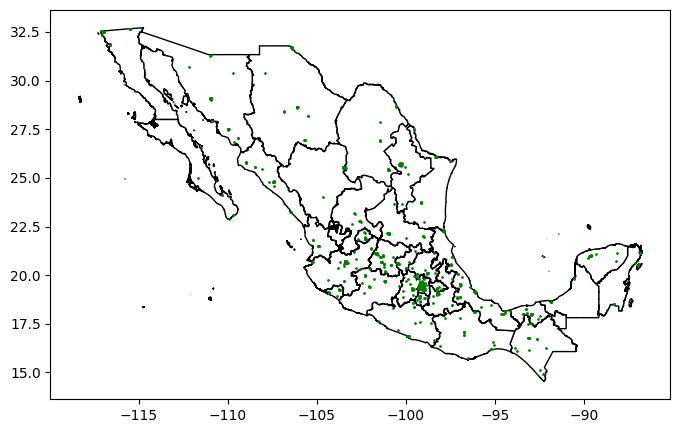

In [36]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_hospitals_mex2.plot(ax=ax, color='green', markersize=1)

## Metro Stations

### Fetch Area

In [124]:
# search for metros
gdf_metro_stations = denue_api.BuscarAreaAct(
    nombre='metro',
    clave_area='00',
    registro_inicial=0,
    registro_final=100_000,
    estrato='0'
)
gdf_metro_stations.shape

(1352, 35)

In [125]:
# filter by CLASE_ACTIVIDAD_ID = 485114
gdf_metro_stations = gdf_metro_stations.query("CLASE_ACTIVIDAD_ID == '485114'").reset_index(drop=True)
gdf_metro_stations.shape

(414, 35)

In [126]:
# see a sample
gdf_metro_stations.sample(5)

CLEE       Id  \
53   09005485114000251000014124S2  9436388   
307  09016485114000023000014124S2   685665   
4    09015485114000971000014124S4  9456991   
96   09017485114000311000014124S9  7747231   
24   19039485114000111000055421S5  2967437   

                                                Nombre  \
53                       ESTACION DEL METRO  MISTERIOS   
307                  ESTACION DEL METRO TACUBA LINEA 2   
4    EDIFICIO DE LA ESTACION DEL METRO ISABEL LA CA...   
96               ESTACION DEL METRO CANDELARIA LINEA 4   
24                      ESTACION ALFONSO REYES LINEA 1   

                                   Razon_social  \
53       SISTEMA DE TRANSPORTE COLECTIVO METRO    
307                                               
4        SISTEMA DE TRANSPORTE COLECTIVO METRO    
96       SISTEMA DE TRANSPORTE COLECTIVO METRO    
24   SISTEMA DE TRANSPORTE COLECTIVO METRORREY    

                                       Clase_actividad           Estrato  \
53   Transporte colectivo urbano y suburbano de pas...    0 a 5 personas   
307  Transporte colectivo urbano y suburbano de pas...  11 a 30 personas   
4    Transporte colectivo urbano y suburbano de pas...    0 a 5 personas   
96   Transporte colectivo urbano y suburbano de pas...    0 a 5 personas   
24   Transporte colectivo urbano y suburbano de pas...    0 a 5 personas   

    Tipo_vialidad                             Calle Num_Exterior Num_Interior  \
53       CIRCUITO  INTERIOR (AVENIDA RÍO CONSULADO)                             
307       CALZADA                     MÉXICO-TACUBA          789                
4         AVENIDA                JOSÉ MARÍA IZAZAGA           70                
96          CALLE                     GENERAL ANAYA                             
24        AVENIDA                     RODRIGO GÓMEZ                             

             Colonia     CP  \
53        PERALVILLO  07870   
307           TACUBA  11410   
4             CENTRO  06000   
96   MERCED BALBUENA  15810   
24           CENTRAL  64320   

                                             Ubicacion Telefono Correo_e  \
53            CUAUHTÉMOC, Cuauhtémoc, CIUDAD DE MÉXICO                     
307   MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO                     
4             CUAUHTÉMOC, Cuauhtémoc, CIUDAD DE MÉXICO                     
96   VENUSTIANO CARRANZA, Venustiano Carranza, CIUD...                     
24                 MONTERREY, Monterrey, NUEVO LEÓN                        

    Sitio_internet  Tipo    Longitud    Latitud tipo_corredor_industrial  \
53                  Fijo  -99.130731  19.463071                            
307                 Fijo  -99.187131  19.459033                            
4                   Fijo  -99.137826  19.426425                            
96                  Fijo  -99.119919  19.427944                            
24                  Fijo -100.342600  25.715808                            

    nom_corredor_industrial numero_local  AGEB Manzana CLASE_ACTIVIDAD_ID  \
53                                        0023     013             485114   
307                              LINEA 2  0158     015             485114   
4                                         088A     012             485114   
96                                        0583     002             485114   
24                                        064A     016             485114   

    EDIFICIO_PISO SECTOR_ACTIVIDAD_ID SUBSECTOR_ACTIVIDAD_ID  \
53                                 48                    485   
307                                48                    485   
4                                  48                    485   
96                                 48                    485   
24                                 48                    485   

    RAMA_ACTIVIDAD_ID SUBRAMA_ACTIVIDAD_ID EDIFICIO Tipo_Asentamiento  \
53               4851                48511                    COLONIA   
307              4851                48511               

In [127]:
# see cve_ents
gdf_metro_stations['AreaGeo'].str[:2].value_counts()

AreaGeo
09    352
19     35
15     23
11      3
14      1
Name: count, dtype: int64

In [128]:
# drop rows with cve_ents eq to 11 or 14
mask = gdf_metro_stations['AreaGeo'].str[:2].isin(['11', '14'])
gdf_metro_stations = gdf_metro_stations[~mask].reset_index(drop=True)
gdf_metro_stations.shape

(410, 35)

In [129]:
# count unique values
gdf_metro_stations['Id'].nunique()

410

<Axes: >

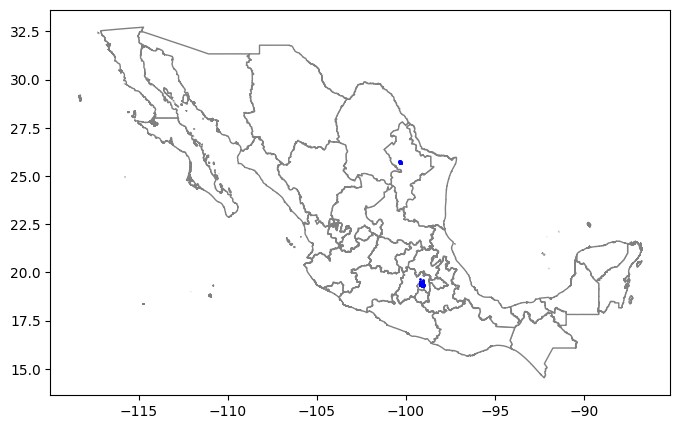

In [149]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='gray')
gdf_metro_stations.plot(ax=ax, color='blue', markersize=1)


<Axes: >

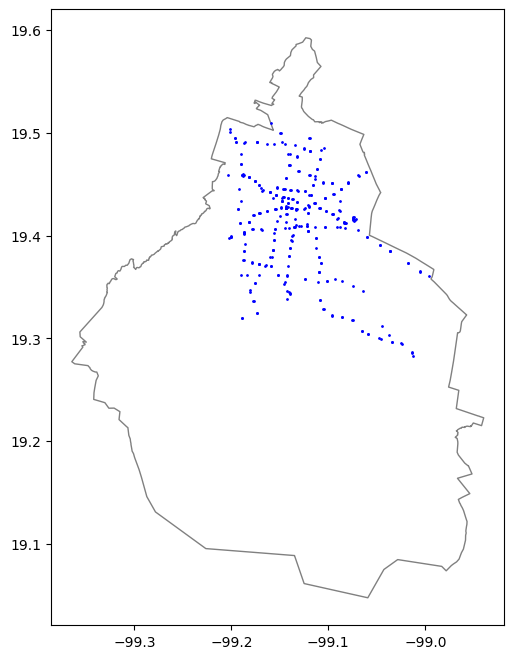

In [150]:
# zoom to cdmx
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico[gdf_mexico['cvegeo'] == '09'].plot(ax=ax, color='white', edgecolor='gray')
gdf_metro_stations[gdf_metro_stations['AreaGeo'].str[:2] == '09'].plot(ax=ax, color='blue', markersize=1)

In [97]:
# explore
(
    gdf_metro_stations
    .explore(tiles='cartodb positron')
)

^^^
there are some stations that are very very near. should get only one of them

### Clean

In [142]:
# get longitude & latitude
gdf_metro_stations = gdf_metro_stations.to_crs('EPSG:6372')
gdf_metro_stations['longitude'] = gdf_metro_stations.centroid.x
gdf_metro_stations['latitude'] = gdf_metro_stations.centroid.y
# return to 4326
gdf_metro_stations = gdf_metro_stations.to_crs('EPSG:4326')

In [162]:
# use dbscan to cluster metro stations
eps = 100 # 100 meters
min_samples = 2

# get clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
gdf_metro_stations['cluster'] = dbscan.fit_predict(gdf_metro_stations[['latitude', 'longitude']])

In [163]:
# see clusters
gdf_metro_stations['cluster'].value_counts()

cluster
-1      165
 2        7
 0        5
 88       5
 14       3
       ... 
 42       2
 41       2
 40       2
 39       2
 104      2
Name: count, Length: 106, dtype: int64

In [164]:
# plot clusters that are not -1
(
    gdf_metro_stations
    .query("cluster != -1")
    .explore(tiles='cartodb positron', tooltip='cluster')
)

In [165]:
# get only first observation for each cluster
gdf_metro_unique_clusters = gdf_metro_stations.query("cluster == -1").copy()
gdf_metro_multiple_clusters = gdf_metro_stations.query("cluster != -1").drop_duplicates('cluster', keep='first').copy()

# for multiple clusters, get the average of latitude and longitude
gdf_metro_multiple_clusters['longitude'] = gdf_metro_multiple_clusters.groupby('cluster')['longitude'].transform('mean')
gdf_metro_multiple_clusters['latitude'] = gdf_metro_multiple_clusters.groupby('cluster')['latitude'].transform('mean')

# join
gdf_metro_stations2 = pd.concat([gdf_metro_unique_clusters, gdf_metro_multiple_clusters], axis=0)
gdf_metro_stations2.shape

# set new geometry
gdf_metro_stations2['geometry'] = gdf_metro_stations2.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
gdf_metro_stations2 = gpd.GeoDataFrame(gdf_metro_stations2, geometry='geometry', crs='EPSG:6372')

# change crs
gdf_metro_stations2 = gdf_metro_stations2.to_crs('EPSG:4326')


In [166]:
gdf_metro_stations2.explore(tiles='cartodb positron', tooltip='cluster')

<Axes: >

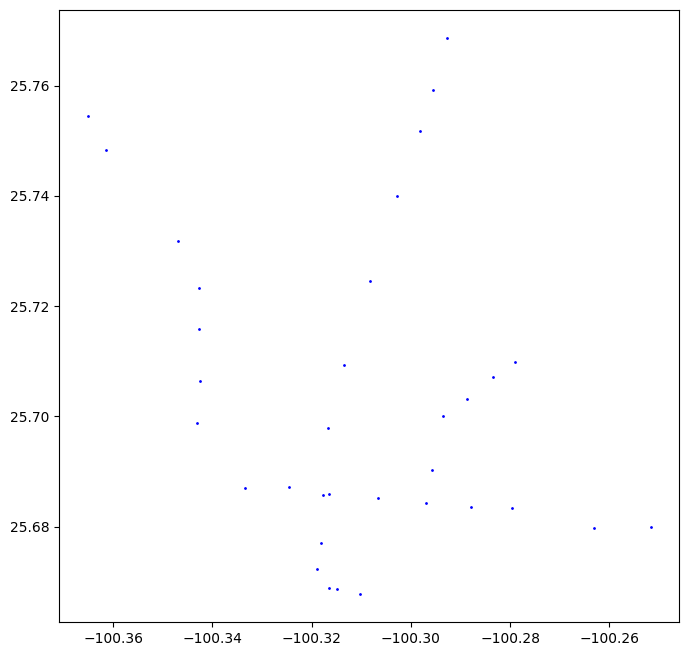

In [170]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
# gdf_mexico[gdf_mexico['cvegeo'] == '19'].plot(ax=ax, color='white', edgecolor='gray')
gdf_metro_stations2[gdf_metro_stations2['AreaGeo'].str[:2] == '19'].plot(ax=ax, color='blue', markersize=1)

In [152]:
# see gdf
gdf_metro_stations2

CLEE       Id  \
0    09003485114000231000014124S9  9459502   
7    09016485114000241000014124S0  9409879   
12   09010485114000101000014124S9  9398168   
14   09015485114000107000014124S5  1060505   
19   09003485114000221000014124S0  9408502   
..                            ...      ...   
341  09014485114000231000014124S6  9409063   
343  09014485114000191000014124S2  9458540   
345  09011485114000201000014124S5  9457293   
349  09015485114000661000014124S1  9411682   
387  09003485114000031000000000U3   907530   

                                                Nombre  \
0             BODEGA DE LA ESTACION DEL METRO TASQUEÑA   
7                 EDIFICIO DE LA ESTACION METRO NORMAL   
12   EDIFICIO DE SERVICIOS DE LA ESTACION DEL METRO...   
14                EDIFICIO DEL METRO EN CALLE DELICIAS   
19   EDIFICO DE SERVICIOS CONJUNTO DE LA ESTACION D...   
..                                                 ...   
341                            ESTACION DEL METRO XOLA   
343                 ESTACION DEL METRO ZAPATA LINEA 12   
345                      ESTACION DEL METRO ZAPOTITLAN   
349              ESTACION DEL METRO ZOCALO TENOCHITLAN   
387                                           METROBUS   

                                          Razon_social  \
0               SISTEMA DE TRANSPORTE COLECTIVO METRO    
7               SISTEMA DE TRANSPORTE COLECTIVO METRO    
12              SISTEMA DE TRANSPORTE COLECTIVO METRO    
14              SISTEMA DE TRANSPORTE COLECTIVO METRO    
19              SISTEMA DE TRANSPORTE COLECTIVO METRO    
..                                                 ...   
341             SISTEMA DE TRANSPORTE COLECTIVO METRO    
343             SISTEMA DE TRANSPORTE COLECTIVO METRO    
345             SISTEMA DE TRANSPORTE COLECTIVO METRO    
349             SISTEMA DE TRANSPORTE COLECTIVO METRO    
387  CONCESIONADO AL SISTEMA DE CORREDORES DE TRANS...   

                                       Clase_actividad             Estrato  \
0    Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
7    Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
12   Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
14   Transporte colectivo urbano y suburbano de pas...  251 y más personas   
19   Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
..                                                 ...                 ...   
341  Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
343  Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
345  Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
349  Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   
387  Transporte colectivo urbano y suburbano de pas...      0 a 5 personas   

    Tipo_vialidad                     Calle Num_Exterior Num_Interior  \
0           CALLE            CERRO DE JESÚS           17                
7           CALLE                    TLÁLOC            1                
12          CALLE               PONIENTE 85            2                
14          CALLE                  DELICIAS           67                
19          CALLE                   NINGUNO           17                
..            ...                       ...          ...          ...   
341       CALZADA        CALZADA DE TLALPAN          656                
343      EJE VIAL      7 SUR (FÉLIX CUEVAS)                             
345       AVENIDA                   TLÁHUAC                             
349         CALLE  PLAZA DE LA CONSTITUCIÓN                             
387                                 NINGUNO                             

                  Colonia     CP  \
0              CHURUBUSCO  04210   
7                TLAXPANA  11370   
12                  COVER  01120   
14                 CENTRO  06000   
19             CHURUBUSC0  04210   
..                    ...    ...   
341             

## Schools

### Fetch all info

In [173]:
# search for schools
def get_schools(list_of_names):
    # fetch each name
    list_schools_df = []

    for name in tqdm(list_of_names):
        gdf = denue_api.BuscarAreaAct(
            nombre=name,
            clave_area='00',
            registro_inicial=0,
            registro_final=100_000,
            estrato='0'
        )
        list_schools_df.append(gdf)
    
    # append
    df_append = pd.concat(list_schools_df, axis=0)

    # filter by CLASE_ACTIVIDAD_ID = 611311 & 611312
    df_append = (
        df_append
        .query("CLASE_ACTIVIDAD_ID.isin(['611311', '611312'])")
        # drop duplicates on CLEE
        .drop_duplicates('CLEE', keep='first')
        .reset_index(drop=True)
        )
    
    return df_append

# list of schools
list_of_school_names = [
    'universidad', 'escuela', 'colegio', 'instituto', 'campus'
]

# get schools
gdf_schools_mex = get_schools(list_of_school_names)

# see shape
print(gdf_schools_mex.shape)
gdf_schools_mex.sample(5)

100%|██████████| 5/5 [01:21<00:00, 16.23s/it]


In [174]:
# see shape
print(gdf_schools_mex.shape)
gdf_schools_mex.sample(5)

(7359, 35)


CLEE       Id  \
7301  26018611312000011000000000U9  3862107   
2416  29033611171000116001000000U2  6406310   
5249  09012611312000087000000000U3  1059374   
4858  07101611311000092000000000M3  6298960   
743   20334611312000043000000000U9  8532026   

                                                 Nombre  \
7301                                   TEATRO DEL ITSON   
2416                          UNIVERSIDAD DEL ALTIPLANO   
5249                               ENEO ANEXO DEPORTIVO   
4858                                             CEPROG   
743   ESCUELA UNIVERSITARIA EN SISTEMA DE BIODIVERSI...   

                                           Razon_social  \
7301                   INSTITUTO TECNOLOGICO DE SONORA    
2416      SUPERACIÓN EDUCATIVA Y CULTURA DE TLAXCALA SC   
5249                                              UNAM    
4858   CENTRO DE ESTUDIOS PROFESIONALES DEL GRIJALVA SA   
743   UNIVERSIDAD PARA EL BINESTAR BENITO JUAREZ GAR...   

                                        Clase_actividad             Estrato  \
7301  Escuelas de educación superior del sector público      0 a 5 personas   
2416  Escuelas de educación superior del sector privado  101 a 250 personas   
5249  Escuelas de educación superior del sector público  251 y más personas   
4858  Escuelas de educación superior del sector privado    31 a 50 personas   
743   Escuelas de educación superior del sector público    11 a 30 personas   

     Tipo_vialidad                 Calle Num_Exterior Num_Interior  \
7301                RODOLFO ELÍAS CALLES            0                
2416         CALLE             EUCALIPTO            1                
5249         CALLE     MEXICO-XOCHIMILCO                             
4858     BOULEVARD    ANGEL ALBINO CORZO         1089            0   
743      CARRETERA         LOCALIDAD 800            0            0   

                             Colonia     CP  \
7301                          CENTRO          
2416                      EL SABINAL  90102   
5249  PUEBLO DE SAN LORENZO HUIPULCO  14080   
4858                    LOS CHOFERES  29040   
743                      VALLE VERDE  71830   

                                              Ubicacion    Telefono  \
7301                     CIUDAD OBREGÓN, Cajeme, SONORA  6444100900   
2416                        OCOTLÁN, Tlaxcala, TLAXCALA  2461111642   
5249                 TLALPAN, Tlalpan, CIUDAD DE MÉXICO  5556553181   
4858        TUXTLA GUTIÉRREZ, Tuxtla Gutiérrez, CHIAPAS  9161003956   
743   EL CHAMUSCADERO, Villa de Tututepec de Melchor...  9541118431   

                   Correo_e               Sitio_internet  Tipo    Longitud  \
7301        TEATRO@ITSON.MX                 WWW.ITSON.MX  Fijo -109.932256   
2416  CONTAUDA@YAHOO.COM.MX  WWW.UNIVERSIDADDELALTIPLANO  Fijo  -98.211190   
5249    INFO.ENEO@GMAIL.COM             WWW.ENEO.UNAM.MX  Fijo  -99.151334   
4858   JMCEPROG@HOTMAIL.COM           WWW.UCEPROG.EDU.MX  Fijo  -93.089394   
743                                                       Fijo  -97.436479   

        Latitud tipo_corredor_industrial nom_corredor_industrial numero_local  \
7301  27.482619                                                                 
2416  19.312120                                                                 
5249  19.292464                                                                 
4858  16.748493                                                                 
743   15.998022                                                                 

      AGEB Manzana CLASE_ACTIVIDAD_ID EDIFICIO_PISO SECTOR_ACTIVIDAD_ID  \
7301  0796     084             611312                                61   
2416  0669     039             611311                                61   
5249  0430     004             611312                                61   
4858  1785     019             611311                                61   
743   0159     800             611312                                61   

     SUBSECTOR_ACTIVIDAD

### Mini EDA

<Axes: >

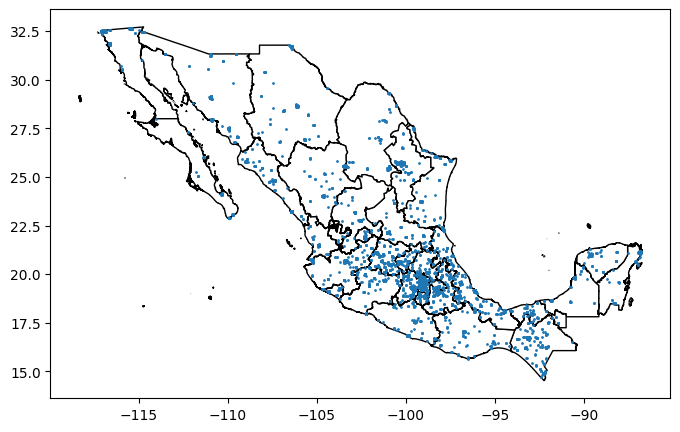

In [175]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_schools_mex.plot(ax=ax, color='C0', markersize=1)


In [177]:
# razon social
gdf_schools_mex['Razon_social'].value_counts().head(20)

Razon_social
                                                     540
UNIVERSIDAD VERACRUZANA                              132
SECRETARIA DE EDUCACION PUBLICA                      126
UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO              123
INSTITUTO PREUNIVERSITARIO MOTOLINIA DE LEON AC      120
INSTITUTO POLITÉCNICO NACIONAL                       115
TECNOLOGICO NACIONAL DE MEXICO                       111
UNIVERSIDAD AUTONOMA DE SINALOA                       93
UNIVERSIDADES TECNOLOGICAS Y POLITÉCNICAS             87
UNIVERSIDAD DE GUADALAJARA                            62
UNIVERSIDAD AUTONOMA DE COAHUILA                      56
SECRETARIA DE EDUCACION DE VERACRUZ                   53
UNIVERSIDAD DEL TERCER MILENIO SC                     51
SECRETARIA DE EDUCACION PÚBLICA                       49
UNIVERSIDAD MICHOACANA DE SAN NICOLAS DE HIDALGO      49
UNAM                                                  49
UNIVERSIDAD AUTONOMA DE GUERRERO                      48
UNIVERSIDAD AUTONO

In [179]:
# count estrato
gdf_schools_mex['Estrato'].value_counts()

Estrato
11 a 30 personas      1954
0 a 5 personas        1212
31 a 50 personas       952
51 a 100 personas      951
6 a 10 personas        936
101 a 250 personas     851
251 y más personas     503
Name: count, dtype: int64

<Axes: xlabel='Fecha_Alta'>

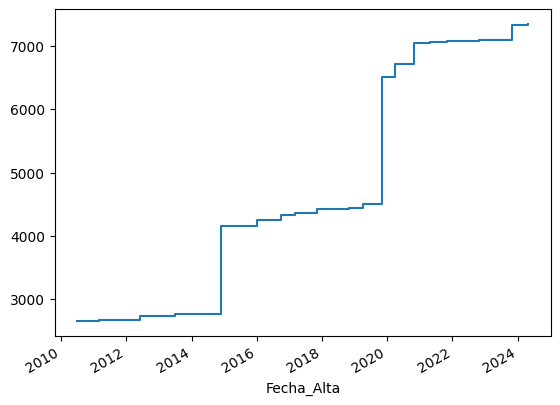

In [180]:
# time series of counts of Fecha_Alta: the date format is 'YYYY-MM'
gdf_schools_mex['Fecha_Alta'] = pd.to_datetime(gdf_schools_mex['Fecha_Alta'], format='%Y-%m', errors='coerce')

# plot ts
(
    gdf_schools_mex
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)


### Subset

In [192]:
# subset
gdf_schools_mex2 = (
    gdf_schools_mex
    .assign(
        estrato_category=lambda x: pd.Categorical(
            x['Estrato'],
            categories=estrato_categories,
            ordered=True
        ),
        Fecha_Alta=lambda x: pd.to_datetime(
            x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
    )
    .astype({
        'CLASE_ACTIVIDAD_ID': 'int64'
    })
    # filters
    .query("estrato_category >= '251 y más personas'")
    # also should have name
    .query("Razon_social != '' & Nombre != ''")
    .reset_index(drop=True)
)

# see
print(gdf_schools_mex2.shape)
gdf_schools_mex2.sample(5)

(499, 36)


CLEE       Id  \
407  15033611171000336010007015S2  6349163   
247  21114611311001506001000000U1  6380414   
140  08019611312000386001000000U5   564995   
428  28022611312000047000000000U3  4037948   
112  02002611311000011001006725S3  6287532   

                                      Nombre  \
407  INSTITUTO TECNICO Y BANCARIO SAN CARLOS   
247                UNIVERSIDAD MESOAMERICANA   
140        UNIVERSIDAD AUTONOMA DE CHIHUAHUA   
428       INSTITUTO TECNOLOGICO DE MATAMOROS   
112                          UNIDEP MEXICALE   

                                          Razon_social  \
407         INSTITUTO TECNICO Y BANCARIO SAN CARLOS AC   
247  CORPORATIVO VANGUARDISTA DE EDUCACION MESOAMER...   
140                 UNIVERSIDAD AUTONOMA DE CHIHUAHUA    
428                     TECNOLOGICO NACIONAL DEMEXICO    
112          UNIVERSIDAD DEL DESARROLLO PROFESIONAL SC   

                                       Clase_actividad             Estrato  \
407  Escuelas de educación superior del sector privado  251 y más personas   
247  Escuelas de educación superior del sector privado  251 y más personas   
140  Escuelas de educación superior del sector público  251 y más personas   
428  Escuelas de educación superior del sector público  251 y más personas   
112  Escuelas de educación superior del sector privado  251 y más personas   

         Tipo_vialidad                   Calle Num_Exterior Num_Interior  \
407              CALLE  VÍA JOSÉ MARÍA MORELOS          182                
247            PRIVADA              LA SOLEDAD          311                
140              CALLE                 NINGUNO                             
428            AVENIDA            LAURO VILLAR            0            0   
112  OTRO(ESPECIFIQUE)     VENUSTIANO CARRANZA         1999                

                         Colonia     CP  \
407                 NUEVO LAREDO  55080   
247  SAN FRANCISCO TEOTIMEHUACAN  72960   
140               CAMPUS II UACH  31125   
428                  TECNOLOGICO  87490   
112        PLUTARCO ELIAS CALLES  21376   

                                             Ubicacion    Telefono  \
407  ECATEPEC DE MORELOS, Ecatepec de Morelos, MÉXI...               
247         HEROICA PUEBLA DE ZARAGOZA, Puebla, PUEBLA               
140                    CHIHUAHUA, Chihuahua, CHIHUAHUA  6144391500   
428           HEROICA MATAMOROS, Matamoros, TAMAULIPAS  8688141017   
112                MEXICALI, Mexicali, BAJA CALIFORNIA               

                         Correo_e        Sitio_internet  Tipo    Longitud  \
407     RUBENMENDIETA@HOTMAIL.COM  WWW.SANCARLOS.EDU.MX  Fijo  -99.042295   
247    CERON.BAUTISTA@HOTMAIL.COM     WWW.UMAWEB.EDU.MX  Fijo  -98.193668   
140                                         WWW.UACH.MX  Fijo -106.142606   
428                                                      Fijo  -97.453451   
112  JOSUE.SALINASR@UNIDEP.EDU.MX         WWW.UNIDEP.MX  Fijo -115.404174   

       Latitud tipo_corredor_industrial nom_corredor_industrial numero_local  \
407  19.576714                                                                 
247  18.978738                                                                 
140  28.708220                                                                 
428  25.844449                                                                 
112  32.622875                                                                 

     AGEB Manzana  CLASE_ACTIVIDAD_ID EDIFICIO_PISO SECTOR_ACTIVIDAD_ID  \
407  4759     036              611311                                61   
247  6483     004              611311                                61   
140  6845     032              611312                                61   
428  164A     007              611312                                61   
112  3916     003              611311                                61   

    SUBSECTOR_ACTIVIDAD_ID RAMA_ACTIVIDAD_ID SUBRAMA_ACTIVIDAD_ID EDIFICIO  \
407                    611         

In [193]:
# count CLASE_ACTIVIDAD_ID
gdf_schools_mex2['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
611312    308
611311    191
Name: count, dtype: int64

<Axes: >

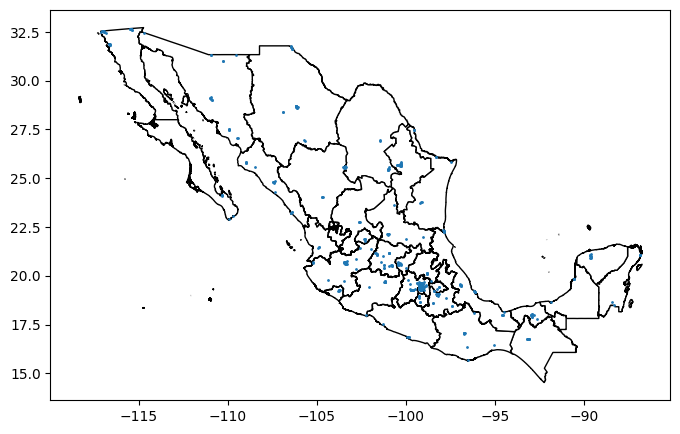

In [194]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))

gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_schools_mex2.plot(ax=ax, color='C0', markersize=1)


In [195]:
# explore
(
    gdf_schools_mex2
    .loc[:, ['Razon_social', 'geometry', 'estrato_category', 'CLASE_ACTIVIDAD_ID', 'Nombre']]
    .explore(tiles='cartodb positron', tooltip=['Razon_social', 'Nombre', 'estrato_category', 'CLASE_ACTIVIDAD_ID'])
)

<Axes: xlabel='Fecha_Alta'>

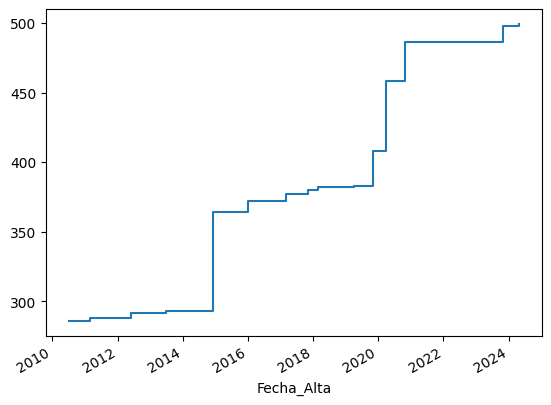

In [196]:
# plot ts
(
    gdf_schools_mex2
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)

## Restaurants

### Fetch all info

In [230]:
# search for schools
def get_denue_info(list_of_names):
    # fetch each name
    list_schools_df = []

    for name in tqdm(list_of_names):
        gdf = denue_api.BuscarAreaAct(
            nombre=name,
            clave_area='00',
            registro_inicial=0,
            registro_final=100_000,
            estrato='0'
        )
        list_schools_df.append(gdf)
    
    # append
    df_append = pd.concat(list_schools_df, axis=0)

    # filter by CLASE_ACTIVIDAD_ID = 611311 & 611312
    df_append = (
        df_append
        .query("CLASE_ACTIVIDAD_ID.isin(['722511', '722512'])")
        .query("Tipo == 'Fijo'")
        .drop_duplicates('CLEE', keep='first')
        .reset_index(drop=True)
        )
    
    return df_append

# list of schools
list_of_names = [
    'restaurant', 'cafeteria', 'sushi', 'pizz'
]

# get schools
gdf_restaurants_mex = get_denue_info(list_of_names)

# see shape
print(gdf_restaurants_mex.shape)
gdf_restaurants_mex.sample(5)

100%|██████████| 4/4 [01:20<00:00, 20.15s/it]


(9464, 35)


CLEE       Id                        Nombre  \
3658  09003722110001614000000000U6  1015033                  CAFE KOWLOON   
7485  07038722212000031001000000U6  6197543  COCINA ECONÓMICA DOÑA MARTHA   
9321  21114722219026841000000000U4  3364216            TAKUMI BARRA SUSHI   
8390  25006722511003601000000000U3  8247501                    SAKE SUSHI   
2386  32056722512000311000000000U6  7088529          BOCA DEL RIO MARICOS   

                                  Razon_social  \
3658  NUEVE DRAGONES DE COYOACAN S DE RL DE CV   
7485                                             
9321                                             
8390                                             
2386                                             

                                        Clase_actividad           Estrato  \
3658  Restaurantes con servicio de preparación de al...  31 a 50 personas   
7485  Restaurantes con servicio de preparación de al...   6 a 10 personas   
9321  Restaurantes con servicio de preparación de al...    0 a 5 personas   
8390  Restaurantes con servicio de preparación de al...    0 a 5 personas   
2386  Restaurantes con servicio de preparación de pe...    0 a 5 personas   

     Tipo_vialidad                   Calle Num_Exterior Num_Interior  \
3658         CALLE  FELIPE CARRILLO PUERTO            6                
7485       AVENIDA        CENTRAL PONIENTE            0            0   
9321         CALLE                  24 SUR         3910            0   
8390     BOULEVARD    ENRIQUE FELIX CASTRO         2042            3   
2386     BOULEVARD     ADOLFO LOPEZ MATEOS          309                

               Colonia     CP                                   Ubicacion  \
3658    VILLA COYOACAN  04100        COYOACÁN, Coyoacán, CIUDAD DE MÉXICO   
7485           LA PILA  29470                   HUIXTÁN, Huixtán, CHIAPAS   
9321          ALSESECA  72540  HEROICA PUEBLA DE ZARAGOZA, Puebla, PUEBLA   
8390  INFONAVIT HUMAYA  80020         CULIACÁN ROSALES, Culiacán, SINALOA   
2386       ZONA CENTRO  98000             ZACATECAS, Zacatecas, ZACATECAS   

        Telefono                        Correo_e Sitio_internet  Tipo  \
3658                                                             Fijo   
7485                                                             Fijo   
9321  2227320641  TAKUMI.BARRA.SUSHI@HOTMAIL.COM                 Fijo   
8390                                                             Fijo   
2386                                                             Fijo   

        Longitud    Latitud tipo_corredor_industrial nom_corredor_industrial  \
3658  -99.163173  19.348893                                                    
7485  -92.453792  16.711859                                                    
9321  -98.192004  19.019985                                                    
8390 -107.410867  24.821896                                                    
2386 -102.569471  22.768901                                                    

     numero_local  AGEB Manzana CLASE_ACTIVIDAD_ID EDIFICIO_PISO  \
3658               0130     022             722511                 
7485               0052     009             722511                 
9321               0785     006             722511                 
8390               3329     004             722511                 
2386               035A     022             722512                 

     SECTOR_ACTIVIDAD_ID SUBSECTOR_ACTIVIDAD_ID RAMA_ACTIVIDAD_ID  \
3658                  72                    722              7225   
7485                  72                    722              7225   
9321                  72                    722              7225   
8390                  72                    722              7225   
2386                  72                    722              7225   

     SUBRAMA_ACTIVIDAD_ID EDIFICIO Tipo_Asentamiento Fecha_Alta    AreaGeo  \
3658                72251                    COLONIA    2010-07  090030001   
7485   

### Mini EDA

<Axes: >

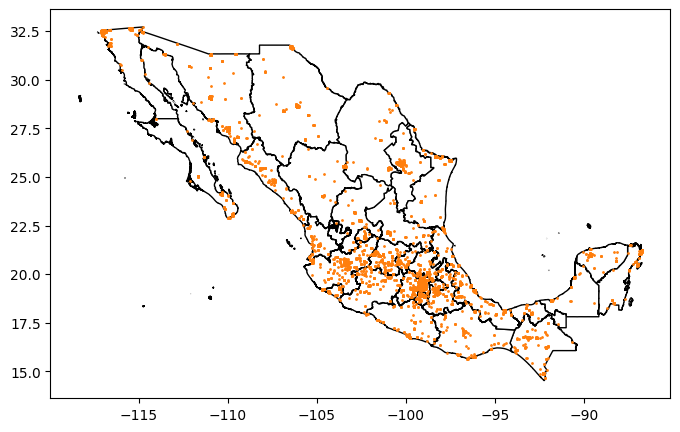

In [231]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_restaurants_mex.plot(ax=ax, color='C1', markersize=1)


In [232]:
# razon social
gdf_restaurants_mex['Razon_social'].value_counts().head(20)

Razon_social
                                                                    7229
GASTRO SUR SA DE CV                                                   69
LAS NUEVAS DELICIAS GASTRONOMICAS S DE RL DE CV                       48
ITALCAFE SA DE CV                                                     36
NOVALIMENTOS DE MEXICO S DE RL DE CV                                  31
SUSHI ROLL SA DE CV                                                   28
ESPECIALISTAS EN RESTAURANTES DE COMIDA ESTILO ASIATICA SA DE CV      27
GRUPO AMIGOS DE SAN ANGEL SA DE CV                                    21
EL SABOR ORIENTAL SA DE CV                                            20
BEER FACTORY DE MEXICO SA DE CV                                       18
RENTASU MEXICANA SA DE CV                                             16
WILD FOODS SA DE CV                                                   14
OCEAN ROLL SA DE CV                                                   14
EXPOGOURMET SA DE CV                  

In [233]:
# name
gdf_restaurants_mex['Nombre'].value_counts().head(20)

Nombre
COCINA ECONÓMICA          109
SUSHI ROLL                 38
COCINA ECONOMICA           31
SUSHI ITTO                 23
CHAI                       21
CHINALOA                   19
CALDOS DE GALLINA          18
COCINA                     18
BODEGA                     18
SUSHI FACTORY              16
BEER FACTORY DE MEXICO     15
BISQUETS OBREGON           15
BUFALO WILD WINGS          14
CHINA EXPRESS              14
BUFFALO WILD WINGS         13
CHILTEPINOS WINGS          13
CARNES ASADAS PIPIOLO      12
MR SUSHI                   12
SUSHI EXPRESS              11
SUSHI                      11
Name: count, dtype: int64

In [234]:
# count estrato
gdf_restaurants_mex['Estrato'].value_counts()

Estrato
0 a 5 personas        5437
6 a 10 personas       1978
11 a 30 personas      1343
31 a 50 personas       378
51 a 100 personas      227
101 a 250 personas      94
251 y más personas       7
Name: count, dtype: int64

<Axes: xlabel='Fecha_Alta'>

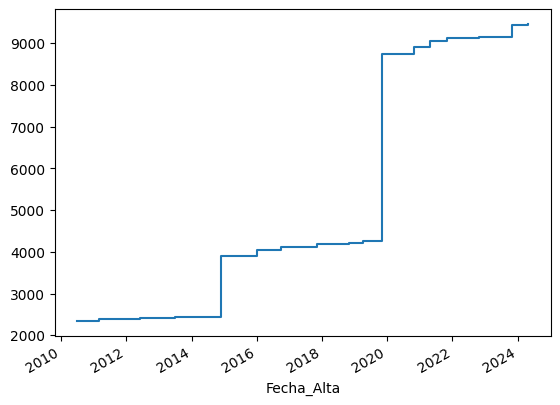

In [235]:
# time series of counts of Fecha_Alta: the date format is 'YYYY-MM'
gdf_restaurants_mex['Fecha_Alta'] = pd.to_datetime(gdf_restaurants_mex['Fecha_Alta'], format='%Y-%m', errors='coerce')

# plot ts
(
    gdf_restaurants_mex
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)


### Subset

In [245]:
# addorn
gdf_restaurants_mex2 = (
    gdf_restaurants_mex
    .assign(
        estrato_category=lambda x: pd.Categorical(
            x['Estrato'],
            categories=estrato_categories,
            ordered=True
        ),
        Fecha_Alta=lambda x: pd.to_datetime(
            x['Fecha_Alta'], format='%Y-%m', errors='coerce'
            )
    )
)

# filter
# mask
mask = (
    (gdf_restaurants_mex2['Nombre'] != '')
    & (
        (
            gdf_restaurants_mex2['estrato_category'].ge('6 a 10 personas')
            & gdf_restaurants_mex2['estrato_category'].le('51 a 100 personas')
            & ~ gdf_restaurants_mex2['CLASE_ACTIVIDAD_ID'].isin(['722514', '722517'])
        )
    )
)

gdf_restaurants_mex2 = (
    gdf_restaurants_mex2
    .loc[mask]
    .reset_index(drop=True)
)

# see
print(gdf_restaurants_mex2.shape)
gdf_restaurants_mex2.sample(5)

(3926, 36)


CLEE       Id                        Nombre  \
154   19019722511002853000037894M2  9041987                    AGUACHILES   
1488  23005722511003703000000000S1  8645101               CAFE ANTOINETTE   
3565  15020722511000523000004464S5  6882633  SUSHI ITTO COSMOPOL COACALCO   
68    09016722511000084001002870S4  6509349        50 FRIENDS PRADO NORTE   
3093  09015722511013613000000000U7  8367168       KABUKI SUSHI RESTAURANT   

                              Razon_social  \
154              EL CHILE VOLADOR SA DE CV   
1488                  TODO SUCEDE SA DE CV   
3565  NOVALIMENTOS DE MEXICO S DE RL DE CV   
68       RELACIONES GASTRONOMICAS SA DE CV   
3093              KABUKI SUSHI RESTAURANT    

                                        Clase_actividad           Estrato  \
154   Restaurantes con servicio de preparación de al...  11 a 30 personas   
1488  Restaurantes con servicio de preparación de al...  11 a 30 personas   
3565  Restaurantes con servicio de preparación de al...  11 a 30 personas   
68    Restaurantes con servicio de preparación de al...  11 a 30 personas   
3093  Restaurantes con servicio de preparación de al...  11 a 30 personas   

     Tipo_vialidad                    Calle Num_Exterior Num_Interior  \
154        AVENIDA  Privada de la Industria          300            0   
1488         CALLE                  NINGUNO            4                
3565         CALLE  VÍA JOSÉ LÓPEZ PORTILLO            1                
68           CALLE              PRADO NORTE          382                
3093         CALLE                TAPACHULA            2            0   

                   Colonia     CP  \
154              VEREDALTA  66270   
1488             SUPMZA 55  77515   
3565     BOSQUES DEL VALLE  55717   
68    LOMAS DE CHAPULTEPEC  11000   
3093            ROMA NORTE  06700   

                                              Ubicacion    Telefono  \
154   SAN PEDRO GARZA GARCÍA, San Pedro Garza García...               
1488                CANCÚN, Benito Juárez, QUINTANA ROO               
3565  SAN FRANCISCO COACALCO, Coacalco de Berriozába...               
68     MIGUEL HIDALGO, Miguel Hidalgo, CIUDAD DE MÉXICO  5610054745   
3093           CUAUHTÉMOC, Cuauhtémoc, CIUDAD DE MÉXICO               

                               Correo_e Sitio_internet  Tipo    Longitud  \
154                                                     Fijo -100.354942   
1488  ENCARGADOTORRES@CFEANTOINETTE.COM                 Fijo  -86.832769   
3565                    KDELGADO@CMR.MX                 Fijo  -99.124479   
68        FERNANDA.IBERRI@CINBERSOL.COM                 Fijo  -99.210363   
3093                                                    Fijo  -99.161264   

        Latitud  tipo_corredor_industrial nom_corredor_industrial  \
154   25.645618                                                     
1488  21.134535                                                     
3565  19.631107  CENTRO Y PLAZA COMERCIAL                COSMOPOL   
68    19.427534                                                     
3093  19.412178                                                     

     numero_local  AGEB Manzana CLASE_ACTIVIDAD_ID EDIFICIO_PISO  \
154                0384     012             722511                 
1488               2466     007             722511                 
3565        D-201  0739     001             722511                 
68                 0887     002             722511                 
3093               1375     013             722511                 

     SECTOR_ACTIVIDAD_ID SUBSECTOR_ACTIVIDAD_ID RAMA_ACTIVIDAD_ID  \
154                   72                    722              7225   
1488                  72                    722              7225   
3565                  72                    722              7225   
68                    72                    722              7225   
3093                  72                    722              7225   

     SUBRAMA_ACTIVIDAD_ID EDIFICIO Tipo_As

In [246]:
# count CLASE_ACTIVIDAD_ID
gdf_restaurants_mex2['CLASE_ACTIVIDAD_ID'].value_counts()

CLASE_ACTIVIDAD_ID
722511    3632
722512     294
Name: count, dtype: int64

<Axes: >

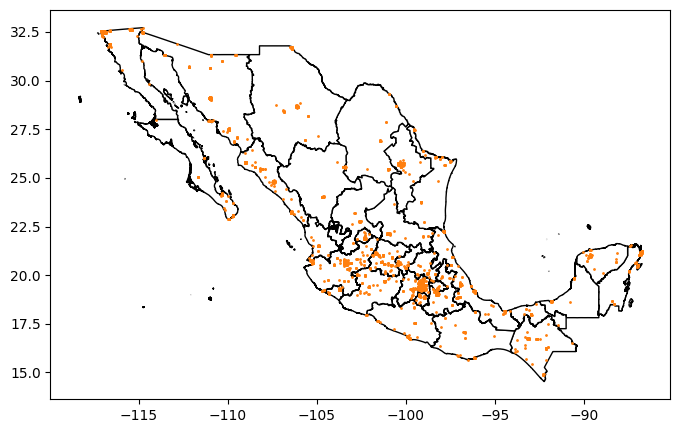

In [247]:
# plot
fig, ax = plt.subplots(figsize=(8, 8))

gdf_mexico.plot(ax=ax, color='white', edgecolor='black')
gdf_restaurants_mex2.plot(ax=ax, color='C1', markersize=1)

In [248]:
# explore
(
    gdf_restaurants_mex2
    .loc[:, ['Razon_social', 'geometry', 'estrato_category', 'CLASE_ACTIVIDAD_ID', 'Nombre']]
    .explore(tiles='cartodb positron', tooltip=['Razon_social', 'Nombre', 'estrato_category', 'CLASE_ACTIVIDAD_ID'])
)

<Axes: xlabel='Fecha_Alta'>

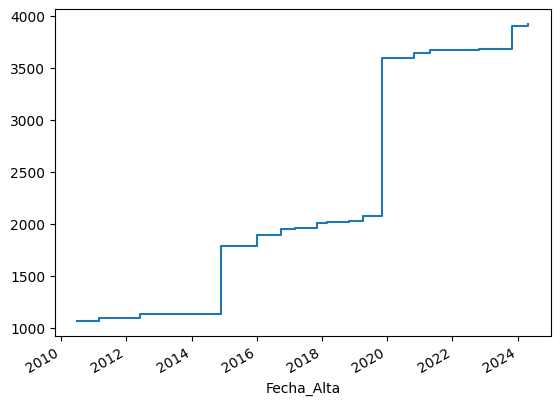

In [240]:
# plot ts
(
    gdf_restaurants_mex2
    .groupby('Fecha_Alta')
    # cum sum
    .size()
    .cumsum()
    .plot(drawstyle='steps-post')
)

## Gyms

In [ ]:
# search for gyms
def get_gyms(list_of_names):
    # fetch each name
    list_df = []

    for name in tqdm(list_of_names):
        gdf = denue_api.BuscarAreaAct(
            nombre=name,
            clave_area='00',
            registro_inicial=0,
            registro_final=100_000,
            estrato='0'
        )
        list_df.append(gdf)
    
    # append
    df_append = pd.concat(list_df, axis=0)

---
# Count of services

In [45]:
# define function to get poiunts at r distance
def get_denues(gdf_props, gdf_denues, r=1):
    # fit a kdtree
    kdtree = KDTree(
        data=gdf_denues[['longitude', 'latitude']],
    )

    # count neighbors at r-km
    return kdtree.query_ball_point(
        gdf_props[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1,
        return_length=True
    )

## Hospitals

In [58]:
# get longitude and latitude
gdf_hospitals_mex2 = gdf_hospitals_mex2.to_crs("EPSG:6372")
gdf_hospitals_mex2['longitude'] = gdf_hospitals_mex2['geometry'].x
gdf_hospitals_mex2['latitude'] = gdf_hospitals_mex2['geometry'].y

In [65]:
# get num hospitals
gdf_properties['hospital_count_nearby'] = get_denues(gdf_properties, gdf_hospitals_mex2, r=5)
gdf_properties['hospital_count_nearby'].describe()

count    852913.000000
mean          2.386698
std           5.289096
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          41.000000
Name: hospital_count_nearby, dtype: float64

In [66]:
# how many props with more than 0 hospitals
print(gdf_properties['hospital_count_nearby'].gt(0).sum())
print(gdf_properties['hospital_count_nearby'].gt(0).mean())

458782
0.5379001140796307


## Supermarkets

In [68]:
# get longitude and latitude
gdf_supermarkets_mex2 = gdf_supermarkets_mex2.to_crs("EPSG:6372")
gdf_supermarkets_mex2['longitude'] = gdf_supermarkets_mex2['geometry'].x
gdf_supermarkets_mex2['latitude'] = gdf_supermarkets_mex2['geometry'].y

In [70]:
# get num supermarkets
gdf_properties['supermarket_count_nearby'] = get_denues(gdf_properties, gdf_supermarkets_mex2, r=1)
gdf_properties['supermarket_count_nearby'].describe()

count    852913.000000
mean          0.975924
std           1.279530
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          11.000000
Name: supermarket_count_nearby, dtype: float64

In [71]:
# how many props with more than 0 supermarkets
print(gdf_properties['supermarket_count_nearby'].gt(0).sum())
print(gdf_properties['supermarket_count_nearby'].gt(0).mean())

437734
0.513222333344667


---
# Sandbox

In [86]:
gdf_mexico

geometry cvegeo cve_agee  \
0   MULTIPOLYGON (((-102.29739 22.45527, -102.2955...     01       01   
1   MULTIPOLYGON (((-114.11561 28.09639, -114.1152...     02       02   
2   MULTIPOLYGON (((-109.89451 22.87476, -109.8946...     03       03   
3   MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...     04       04   
4   MULTIPOLYGON (((-102.31549 29.88000, -102.3150...     05       05   
5   MULTIPOLYGON (((-114.73734 18.37206, -114.7364...     06       06   
6   MULTIPOLYGON (((-91.99567 17.94259, -91.99296 ...     07       07   
7   MULTIPOLYGON (((-108.13866 31.78375, -108.1361...     08       08   
8   MULTIPOLYGON (((-99.12215 19.59248, -99.12078 ...     09       09   
9   MULTIPOLYGON (((-106.03486 26.83507, -106.0331...     10       10   
10  MULTIPOLYGON (((-101.36146 21.83912, -101.3600...     11       11   
11  MULTIPOLYGON (((-99.90610 16.82274, -99.90524 ...     12       12   
12  MULTIPOLYGON (((-98.48554 21.39838, -98.48509 ...     13       13   
13  MULTIPOLYGON (((-104.81446 19.22904, -104.8143...     14       14   
14  MULTIPOLYGON (((-99.91237 20.28563, -99.91180 ...     15       15   
15  MULTIPOLYGON (((-102.01493 20.39447, -102.0144...     16       16   
16  MULTIPOLYGON (((-99.25663 19.11656, -99.22678 ...     17       17   
17  MULTIPOLYGON (((-105.27418 21.04993, -105.2740...     18       18   
18  MULTIPOLYGON (((-100.18800 27.79872, -100.1833...     19       19   
19  MULTIPOLYGON (((-96.22850 15.68753, -96.22837 ...     20       20   
20  MULTIPOLYGON (((-97.84227 20.83991, -97.84218 ...     21       21   
21  MULTIPOLYGON (((-99.18811 21.66992, -99.18362 ...     22       22   
22  MULTIPOLYGON (((-87.38975 18.37417, -87.39099 ...     23       23   
23  MULTIPOLYGON (((-100.68522 24.46974, -100.6422...     24       24   
24  MULTIPOLYGON (((-106.41293 23.17304, -106.4130...     25       25   
25  MULTIPOLYGON (((-110.59080 27.40827, -110.5910...     26       26   
26  MULTIPOLYGON (((-92.46785 18.64728, -92.46677 ...     27       27   
27  MULTIPOLYGON (((-99.72660 27.67728, -99.72576 ...     28       28   
28  MULTIPOLYGON (((-98.05625 19.72602, -98.05599 ...     29       29   
29  MULTIPOLYGON (((-96.09229 19.17375, -96.09240 ...     30       30   
30  MULTIPOLYGON (((-92.22410 20.90800, -92.22470 ...     31       31   
31  MULTIPOLYGON (((-102.29548 25.12519, -102.2665...     32       32   

                           nom_agee nom_abrev       pob  pob_fem  pob_mas  \
0                    Aguascalientes      Ags.   1425607   728924   696683   
1                   Baja California        BC   3769020  1868431  1900589   
2               Baja California Sur       BCS    798447   392568   405879   
3                          Campeche     Camp.    928363   471424   456939   
4              Coahuila de Zaragoza     Coah.   3146771  1583102  1563669   
5                            Colima      Col.    731391   370769   360622   
6                           Chiapas     Chis.   5543828  2837881  2705947   
7                         Chihuahua     Chih.   3741869  1888047  1853822   
8                  Ciudad de México      CDMX   9209944  4805017  4404927   
9                           Durango      Dgo.   1832650   927784   904866   
10                       Guanajuato      Gto.   6166934  3170480  2996454   
11                         Guerrero      Gro.   3540685  1840073  1700612   
12                          Hidalgo      Hgo.   3082841  1601462  1481379   
13                          Jalisco      Jal.   8348151  4249696  4098455   
14                           México      Mex.  16992418  8741123  8251295   
15              Michoacán de Ocampo     Mich.   4748846  2442505  2306341   
16                          Morelos      Mor.   1971520  1020673   950847   
17                          Nayarit      Nay.   1235456   623178   612278   
18                       Nuevo León        NL   5784442  2893492  2890950   
19                           Oaxaca      Oax.   4132148  2157305  1974843   
20                

In [40]:
gdf_hospitals_mex2.shape

(672, 10)

In [39]:
gdf_supermarkets_mex2.shape

(4647, 10)

In [147]:
# columns
gdf_supermarkets.columns

Index(['CLEE', 'Id', 'Nombre', 'Razon_social', 'Clase_actividad', 'Estrato',
       'Tipo_vialidad', 'Calle', 'Num_Exterior', 'Num_Interior', 'Colonia',
       'CP', 'Ubicacion', 'Telefono', 'Correo_e', 'Sitio_internet', 'Tipo',
       'Longitud', 'Latitud', 'CentroComercial', 'TipoCentroComercial',
       'NumLocal', 'geometry'],
      dtype='object')